# Object Removal and Inpainting using Generative Adverserial Network
Project by: Anna Wang, Jimmy Yang and Philip Chen




# Abstract

This project aims to explore the applications of using a Generative Adversarial Network (GANs) to remove objects and inpaint over specific regions in images. The art of object inpainting is a technique used to seamlessly insert or remove objects within an image, often used for image editing or restoration. Given a masked area, we wish to fill in the masked-area with new content that blends realistically with the rest of the image.

Object removal and image inpainting are inherently challenging tasks in computer vision. To help us tackle this project, we employ the use of a special variant of GANs, a Deep Convolutional Generative Adversarial Network (DCGANs). With the help of convolutional layers for image processing, we architected a generator to produce convincing image completions, while the discriminator learns to distinguish between authentic images and the generator's images. As the two models compete in an adversarial process, they both improve their respective abilities, leading to a better trained generator to inpaint masked images.

To evaluate performance, a curated dataset of cat images was used, with manually masked holes of the same size inserted in the middle of all images. This choice of dataset allows for testing the model's ability to handle fine textures like fur and preserve anatomical consistency. The generator performs reasonably well at reconstructing altered parts of the cats body, but struggles when it comes to facial features.

Ultimately, this project highlighted the complexity of the inpainting task. We conclude with several observations and potential directions for improving the model's performance in future work.

# Team Members and Contributions

- Anna Wang (20898072, aj2wang@uwaterloo.ca): I researched and found the dataset of cats and dogs from hugging-face, incorporating, importing and setting up the data for further processing in our notebook. I worked alongside Jimmy to split our dataset into cats and dogs and then the cat dataset into our training, validation and test splits. I also researched with Phillip on the GANs architecture and wrote the code for the Discriminator.Furthermore, I worked alongside Phillip to design and write the training function four our model. As a group, we collectively worked on fine-tuning our models, analyzing our results, iterating on improvements as well as the creation of the reports within our notebook.

- Jimmy Yang (20890430, jj7yang@uwaterloo.ca): I helped curate the dataset of cats to be used in model training. I worked with Anna to split our original dataset into images of cats and defined a custom CatDataset class to help us insert square masks for training purposes. I also explored various model training methods against our dataset to help decide what image resolution to use and how to architect our models. Then, together with the group I contributed to fine-tuning our models, analyzing our results, and iterating on improvements.

- Philip Chen (20902971 , p242chen@uwaterloo.ca): I helped write the function for creating the masks. I also researched and helped design the architecture for our GAN model, as well as writing the code for the Generator. I also worked with Anna to design and write the training function for the model. Finally, together with the group I contributed to fine-tuning our models, analyzing our results, and iterating on improvements.

# 1. Code Libraries

The following external Python libraries were essential to the development and implementation of this project:

- NumPy:
Used for efficient numerical operations and array manipulation throughout the project, particularly when handling image masks, pixel data, and preprocessing pipelines.

- Matplotlib:
Used for visualizing training progress, loss curves, and before-and-after comparisons of image inpainting results. It plays a key role in debugging and showcasing the model's performance.

- PyTorch:
Foundational deep learning framework for this project. It enabled the construction and training of the GAN architecture through its neural network modules and optimization tools.

In [1]:
# Standard libraries for math and plotting
import numpy as np
import matplotlib.pyplot as plt

# Standard PyTorch for network training
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.utils as vutils

# Other utilities and misc
import os
from copy import deepcopy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 2. Importing Dataset

Our dataset comes from Hugging Face Dataset cats_vs_dogs: https://huggingface.co/datasets/microsoft/cats_vs_dogs. From the dataset, we filter for images of cats and split up training, validation, and testing sets. We chose this dataset because of the quality and large number of samples within the dataset with a diverse range of features and expressions of cats in images. This will provide a robust dataset for our GANs to train over.

We install the standard `datasets` library to use the dataset in our training.

In [ ]:
# uncomment cli login if need to login
# !huggingface-cli login
# !pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

### 2.1 Importing Cats vs. Dogs Dataset

In [4]:
from datasets import load_dataset

ds = load_dataset("microsoft/cats_vs_dogs")

print(ds['train'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})


### 2.2 Filtering Dataset by Cats and Dogs
Since this dataset contains pictures of both cats and dogs, we must filter our dataset so our final dataset includes only cat photos.

In [5]:
# filtering data by cats and dogs
data = ds['train']
dogs = data.filter(lambda isDog: isDog['labels'] == 1)
cats = data.filter(lambda isDog: isDog['labels'] == 0)
print("Dataset size: " + str(len(data)))

print("Total dataset size:", len(data))
print("Dogs:", len(dogs))
print("Cats:", len(cats))

Filter:   0%|          | 0/23410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/23410 [00:00<?, ? examples/s]

Dataset size: 23410
Total dataset size: 23410
Dogs: 11669
Cats: 11741


### 2.3 Splitting each class into training, validation and test sets
We split our dataset into training, validation, and test sets to ensure robust and unbiased model development. The training set is used to teach the GAN how to perform image imprinting and object removal on cat photos. The validation set helps us tune hyperparameters and monitor performance during training, allowing us to prevent overfitting. Finally, the test set provides an unbiased evaluation of how well the trained GAN generalizes to new, unseen data. In the code, the dataset is split into 80% training and 20% test, with the test portion further divided equally to create separate validation and test sets. We print the size of each dataset to show the size of the splits.

Training dataset size: 9392
Validation dataset size: 1174
Test dataset size: 1175


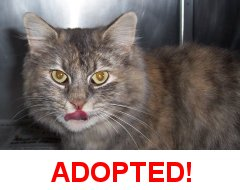

In [6]:
# Split the dataset
train_test_split = cats.train_test_split(test_size=0.2, seed=42)
test_val_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)
train_dataset = train_test_split['train']['image']
val_dataset = test_val_split['train']['image']
test_dataset = test_val_split['test']['image']

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
train_dataset[0]

# 3. Creating Data Loaders

### 3.1 Masks

In order to create training samples for our model, we create the function `create_masks` that cuts out the center of an image of size `hole_size`. We acknowledge that designing a network model for inpainting has a number of challenges. To simplify the project, we assume that the holes are always square, and that they are always in the center and have the same size. The central region is surrounded by image context on all four sides—top, bottom, left, and right. This gives the model rich, balanced context to infer what the missing content should look like. During training, consistently masking the center allows the model to focus its capacity on learning to inpaint a specific region. This makes convergence faster and often leads to better initial performance compared to random or irregular masking. Future improvements to the model would be to allow for custom created masks.

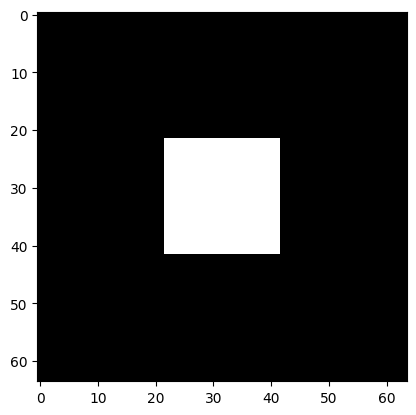

In [7]:
def create_masks(num_masks):
    hole_size = 20
    im_size = 64

    x = int((im_size - hole_size) / 2.0)
    y = int((im_size - hole_size) / 2.0)
    mask = torch.zeros((1, im_size, im_size))
    mask[0, y : y + hole_size, x : x + hole_size] = 1
    masks = mask.repeat_interleave(num_masks, dim=0)

    return masks.unsqueeze(1)

plt.imshow(create_masks(1)[0][0], cmap='gray')
plt.show()

### 3.2 Creating Cat Dataset Definition

The following class defines our Cat Dataset

In [8]:
class CatDataset(Dataset):
    def __init__(self, all_imgs, transforms=None) -> None:
        super().__init__()
        self.transforms = transforms
        self.all_imgs = all_imgs

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, index):
        image = self.all_imgs[index]

        # 1. Transform the image as needed
        transformed_img = self.transforms(image)

        if transformed_img.shape[0] == 1:
            transformed_img = transformed_img.repeat(3, 1, 1)

        # 2. Create copy of image before masking
        ground_truth_image = deepcopy(transformed_img)

        # 3. Create center mask depending of transformed image
        mask = create_masks(1)[0]
        transformed_img = (1 - mask) * transformed_img

        return transformed_img, ground_truth_image

### 3.3 Transformations

While composing our dataset, we experiments with several transformations, including what image resolution to train on, various crops, and flips. We landed on the resolution of 64x64 because it would allow the images to retain just enough detail to make out facial features (ie. eyes, nose, mouth), as opposed to smaller resolutions like 32x32 that would make the images almost unrecognizable as cats. 

Our original cat dataset consists of images with a wide range of resolutions and aspect ratios, which can introduce inconsistency during training. By applying transformations that resize all images to a uniform resolution of 64x64, we not only standardize the input data for our model but also ensure that each image consistently highlights key facial features—such as the eyes, nose, and mouth—that are essential for effective image imprinting and object removal. This preprocessing step improves model performance and stability by reducing variability unrelated to the task.

In [9]:
transforms = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Resize(size=(64, 64))
])

transformed_train_dataset = CatDataset(train_dataset, transforms=transforms)
transformed_val_dataset = CatDataset(val_dataset, transforms=transforms)
transformed_test_dataset = CatDataset(test_dataset, transforms=transforms)

### 3.4 Explore Dataset
To visually confirm that our preprocessing pipeline is working as intended, we display several pairs of training images alongside their corresponding ground truth images. This allows us to directly evaluate whether the applied transformations—such as resizing and cropping—have successfully standardized the input to 64x64 resolution while preserving essential facial features like the eyes, nose, and mouth. By inspecting these visualizations, we can also verify that the generated masks for object removal are accurately positioned, effectively covering key regions of the cat's face necessary for the imprinting task.

In [10]:
# Grab pictures of just cats, some other pictures have their owners in the background
image0, image1, image2 = transformed_train_dataset[1], transformed_train_dataset[3], transformed_train_dataset[10]

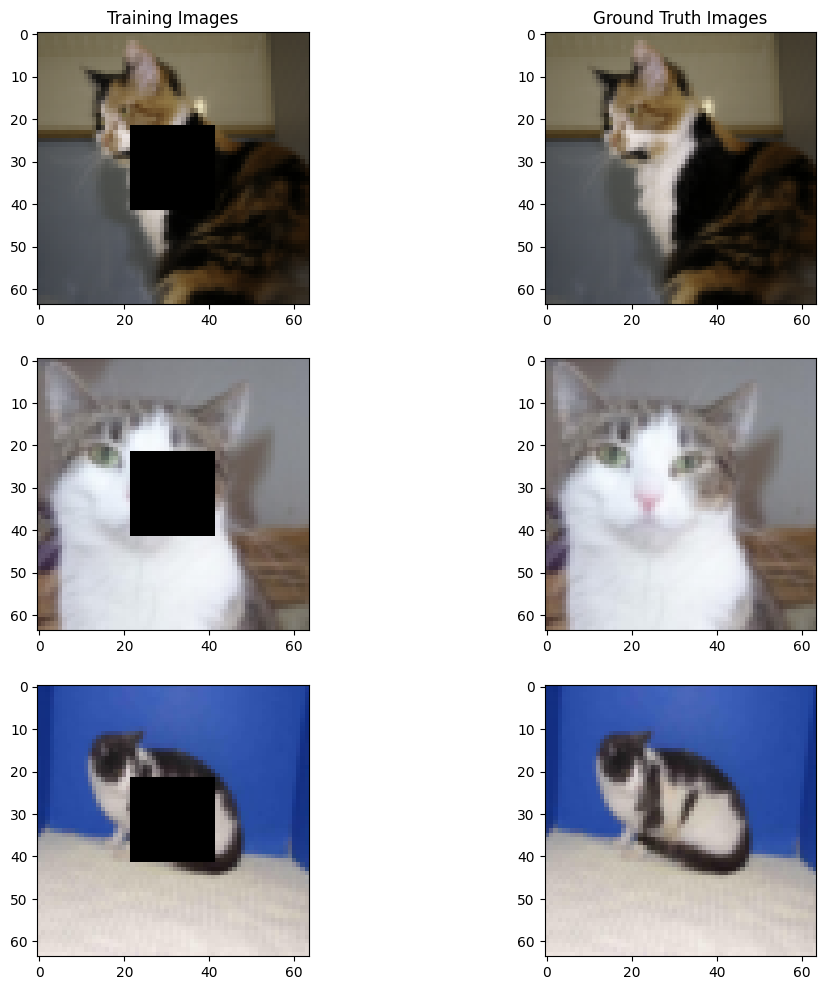

In [11]:
# Display training images and their ground truth images
f, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].imshow(np.transpose(image0[0], (1, 2, 0)))
ax[0, 1].imshow(np.transpose(image0[1], (1, 2, 0)))
ax[1, 0].imshow(np.transpose(image1[0], (1, 2, 0)))
ax[1, 1].imshow(np.transpose(image1[1], (1, 2, 0)))
ax[2, 0].imshow(np.transpose(image2[0], (1, 2, 0)))
ax[2, 1].imshow(np.transpose(image2[1], (1, 2, 0)))

ax[0, 0].set_title("Training Images");
ax[0, 1].set_title("Ground Truth Images");


### 3.5 Setup Dataloader
We set up a data loader to efficiently feed batches of images into our model during training, validation, and testing. The `DataLoader` handles the loading and batching of data in a way that optimizes memory usage and speeds up training, especially when working with large datasets. By setting a `BATCH_SIZE` of 8, we strike a balance between computational efficiency and gradient stability—small enough to fit into memory without overwhelming the GPU, but large enough to provide stable gradient estimates during backpropagation. Shuffling the data ensures that each batch contains a diverse set of examples, which helps prevent the model from learning spurious patterns tied to the order of the dataset.

In [12]:
train_dataset, val_dataset, test_dataset = transformed_train_dataset, transformed_val_dataset, transformed_test_dataset

In [13]:
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4. GAN Model

The special type of GANs we plan to use is an DCGANs, which is a variation of the deep learning models composed of two convolutional neural networks — a generator and a discriminator — trained in opposition. In image processing tasks like inpainting, super-resolution, or style transfer, DCGANs learn to generate realistic images by mimicking the distribution of real images.

The generator aims to produce realistic images that can fool the discriminator. For image processing tasks like inpainting, the generator is conditioned to a masked input image with the center noise.

In the end, the goal is to minimize the loss of our model, which from [lec12](https://cs.uwaterloo.ca/~yboykov/Courses/cs484/Lectures/lec12_weak_supervision.pdf?r=0.299853984606967), we know to be:


$$
\min_{w} \max_{\theta}
\left(
- \sum_{i \in \mathit{Real}} \ln \sigma_w(I_i)
- \sum_{i \in \mathit{Fake}} \ln \left(1 - \sigma_w(I_{\theta}(z_i)) \right)
\right)
$$

We experimented various architectures, referencing various academic papers for inspiration. We took inspiration from [S. Iizuka, E. Simo-Serra, H. Ishikawa](https://iizuka.cs.tsukuba.ac.jp/projects/completion/data/completion_sig2017.pdf), modifying the architecture to fit our needs. One notable difference we chose to not take from the paper was the use of 2 discriminators, a global one and local one. To simplify our training we instead had one regular discriminator that functions as a simple CNN to classify between authentic and generated images. However, as next steps, we can definitely try experimenting with two discriminators. 

The generator uses an encoder-decoder structure with convolutional layers to extract spatial features and deconvolutional layers to reconstruct the full image. Dilated convolutions expand the receptive field, helping the model capture broader context for coherent inpainting. Batch normalization stabilizes training and improves convergence. The generator's input is also 4-channels instead of 3 where the 4th channel is the mask. We included the mask to give the model more contextual information, with the goal of enhancing the learning process. The discriminator, designed as a patch-based classifier, uses convolution and down-sampling to evaluate image realism, focusing on structural and textural consistency. This adversarial setup pushes the generator to create realistic, context-aware content. Together, these components enable effective learning of both local details and global patterns for high-quality image inpainting.

### 4.1 Generator

In [14]:
class Generator(nn.Module):
    """
        This is the generator class. The generator takes in a masked image and its job is to inpaint (fill in) the
        missing part of the masked image.

        The architecture of the generator is inspired by the generator in the article mentioned
        earlier:
            1) 4x64x64    -> 64x64x64
            2) 64x64x64   -> 128x32x32
            3) 128x32x32  -> 256x16x16
            4) 256x16x16  -> 256x16x16
            5) 256x16x16  -> 256x14x14
            6) 256x14x14  -> 256x8x8
            7) 256x8x8    -> 256x8x8
            8) 256x8x8    -> 128x16x16
            9) 128x16x16  -> 128x16x16
            10) 128x16x16  -> 64x32x32
            11) 64x32x32   -> 64x64x64
            12) 64x64x64   -> 64x64x64
            13) 64x64x64   -> 3x64x64
    """

    def __init__(self, im_channels):
        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(im_channels + 1, 64, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        # Dilation
        self.conv5 = nn.Conv2d(256, 256, 3, stride=1, padding=1, dilation=2)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=1, padding=1, dilation=4)
        self.conv7 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        # Decoder
        self.deconv8 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.conv9 = nn.Conv2d(128, 128, 3, stride=1, padding=1)

        self.deconv10 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv11 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv12 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv13 = nn.Conv2d(64, 3, 3, stride=1, padding=1)

        # Batch norms for each layer
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(256)
        self.bn7 = nn.BatchNorm2d(256)
        self.bn8 = nn.BatchNorm2d(128)
        self.bn9 = nn.BatchNorm2d(128)
        self.bn10 = nn.BatchNorm2d(64)
        self.bn11 = nn.BatchNorm2d(64)
        self.bn12 = nn.BatchNorm2d(64)

        # Activation Functions
        self.relu = torch.nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # Encoder layers
        x1 = self.bn1(self.relu(self.conv1(x)))
        x2 = self.bn2(self.relu(self.conv2(x1)))
        x3 = self.bn3(self.relu(self.conv3(x2)))
        x4 = self.bn4(self.relu(self.conv4(x3)))

        # Dilation Layers
        x5 = self.bn5(self.relu(self.conv5(x4)))
        x6 = self.bn6(self.relu(self.conv6(x5)))
        x7 = self.bn7(self.relu(self.conv7(x6)))

        # Decoder layers
        x8 = self.bn8(self.relu(self.deconv8(x7)))
        x9 = self.bn9(self.relu(self.conv9(x8)))
        x10 = self.bn10(self.relu(self.deconv10(x9)))
        x11 = self.bn11(self.relu(self.deconv11(x10)))
        x12 = self.bn12(self.relu(self.conv12(x11)))

        output = self.sig(self.conv13(x12))
        return output


### 4.2 Discriminator
Our discriminator is implemented as a straightforward CNN-based binary classifier that takes in a full image and predicts whether it is real or generated. The architecture progresses through a series of convolutional layers with increasing depth, downsampling the input from 3×64×64 to a 512-dimensional feature map. These are followed by fully connected layers that gradually reduce dimensionality, ending in a single sigmoid output. Batch normalization is applied after each convolutional layer to stabilize learning, and ReLU activations are used throughout to introduce non-linearity. We also include global average pooling to compress spatial information before classification, ensuring that the discriminator captures high-level texture and structural patterns across the entire image.

In contrast to the dual-discriminator approach of the original paper, which allowed fine-grained evaluation of local patches within masked regions, our discriminator assesses the realism of the entire image at once. While this may reduce sensitivity to small artifacts within the inpainted region, it simplifies the architecture and training dynamics, making it easier to integrate and debug. As a next step, we plan to explore reintroducing a local discriminator to improve the model’s ability to detect inconsistencies in smaller, high-detail areas.

In [15]:
class Discriminator(nn.Module):
    """
        This is the discriminator class. The discriminator takes in an image and its job is to classify whether the image is generated(fake)
        or real (non-generated).

        The architecture of the network is the same as a simple CNN classifier
        with the following architecture:
            1) 3x64x64   -> 64x32x32
            2) 64x32x32  -> 128x16x16
            3) 128x16X16 -> 256x8x8
            4) 256x8x8   -> 512x4x4
            5) 512x4x4   -> 512x1x1
            6) 512 -> 512
            7) 512 -> 512
            8) 512 -> 256
            9) 256 -> 10
            10) 10 -> 1
    """
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        # Batch norm layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # Linear layers
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        self.fc5 = nn.Linear(10, 1)

        # Activation functions and pooling
        self.down_sample = nn.AvgPool2d(2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forwad pass through the layers
        x = self.down_sample(self.conv1(x))
        x = self.relu(x)
        x = self.bn1(x)

        x = self.down_sample(self.conv2(x))
        x = self.relu(x)
        x = self.bn2(x)

        x = self.down_sample(self.conv3(x))
        x = self.relu(x)
        x = self.bn3(x)

        x = self.down_sample(self.conv4(x))
        x = self.relu(x)
        x = self.bn4(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.sigmoid(x)

        return x

### 4.3 Training
The training loop involves alternating updates between the generator (g) and the discriminator (d) over multiple epochs using a training dataset of masked images and corresponding ground truth images. Each batch includes the masked image (input), the real image (target), and a generated mask indicating the region to inpaint. The discriminator is first trained to distinguish real images from generated (inpainted) ones using binary cross-entropy loss, aiming to assign high scores to real images and low scores to fake ones. After updating the discriminator, the generator is trained to produce inpainted images that can "fool" the discriminator into classifying them as real. The generator also receives the mask as a fourth input channel to guide the inpainting process. Both networks are optimized using their respective optimizers.

Optionally, during training, the model can display validation images to visually track progress. This includes the masked input, the generator’s raw output, the inpainted composite, and the ground truth. Losses for both networks are recorded for analysis, and if verbose is enabled, progress is printed after each epoch.


In [16]:
def train(g, d, train_loader, val_loader, criterion, optimizer_g, optimizer_d, epochs, verbose=False, show_images=False):
    """
    Trains model for image inpainting.

    Args:
        g: The generator model.
        d: The discriminator model.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        criterion: The loss function.
        optimizer_g: Optimizer for the generator.
        optimizer_d: Optimizer for the discriminator.
        epochs: The number of training epochs.
        verbose: If True, prints training progress.
        show_images: If True, displays generated images during validation.
    """
    # Total losses for epoch x batches
    g_losses = []
    d_losses = []

    total_steps = len(train_loader)
    val_iter = iter(val_loader)

    for epoch in range(epochs):
        g.train()
        d.train()

        # Average loss per batch
        g_avg_loss_per_batch = 0
        d_avg_loss_per_batch = 0

        for i, batch in enumerate(train_loader):
            im_masked, im_truth = batch

            # Move data to GPU
            im_masked = im_masked.to(device)
            im_truth = im_truth.to(device)

            # Add the masks as a separate channel
            N = batch[0].shape[0]
            masks = create_masks(N).to(device)
            im_masked = torch.cat((im_masked, masks), dim=1)

            # --- Train Discriminator ---
            d.zero_grad()

            # Train discriminator with ground truth images
            outputs = d(im_truth).view(-1)
            true_labels = torch.ones(N).to(device)
            d_err = criterion(outputs, true_labels)

            # Train discriminator with fake images
            fake_im = g(im_masked)
            inpainted = fake_im * masks[0] + im_masked[:, :3, :, :]
            output = d(inpainted.detach()).view(-1)
            fake_labels = torch.zeros(N).to(device)
            d_err += criterion(output, fake_labels)

            d_err.backward()
            optimizer_d.step()

            # --- Train Generator ---
            g.zero_grad()

            fake_im = g(im_masked)
            inpainted = fake_im * masks[0] + im_masked[:, :3, :, :]
            outputs = d(inpainted).view(-1)

            g_err = criterion(outputs, true_labels)
            g_err.backward()
            optimizer_g.step()

            # Keep track of loss
            g_avg_loss_per_batch += g_err.item()
            d_avg_loss_per_batch += d_err.item()

            g_losses.append(g_err.item())
            d_losses.append(d_err.item())

            if show_images and i == 0:
                g.eval()
                with torch.no_grad():
                    val_batch = next(val_iter)
                    val_masked, val_truth = val_batch

                    # Move validation data to GPU
                    val_masked = val_masked.to(device)
                    val_truth = val_truth.to(device)

                    N = val_masked.shape[0]
                    val_masks = create_masks(N).to(device)
                    val_input = torch.cat((val_masked, val_masks), dim=1)

                    # Inpainting
                    fake_val = g(val_input)
                    inpainted = val_masked * (1 - val_masks) + fake_val * val_masks

                    # Unpainted
                    unpainted = val_truth * (1 - val_masks)

                    # Get first 4 samples
                    idx = slice(0, 4)
                    sample_masked = val_masked[idx]
                    sample_fake = fake_val[idx]
                    sample_inpainted = inpainted[idx]
                    sample_truth = val_truth[idx]

                    images = [sample_masked, sample_fake, sample_inpainted, sample_truth]
                    labels = ["Masked Input", "Generated Output", "Inpainted", "Ground Truth"]

                    # Plot
                    fig, axs = plt.subplots(len(images), 4, figsize=(16, 10))
                    for row in range(len(images)):
                        for col in range(4):
                            img = images[row][col].cpu()
                            img = img.permute(1, 2, 0)  # CxHxW → HxWxC
                            axs[row, col].imshow(img.numpy(), cmap='gray' if img.shape[2] == 1 else None)
                            axs[row, col].axis('off')
                            if col == 0:
                                axs[row, col].set_title(labels[row], fontsize=10, loc='left')
                    plt.tight_layout()
                    plt.show()

                g.train()

        if verbose:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{total_steps}], '
                    f'Discriminator Loss: {(d_avg_loss_per_batch/total_steps):.4f}, '
                    f'Generator Loss: {(g_avg_loss_per_batch/total_steps):.4f}')

    return g_losses, d_losses

We first do a basic training of our model. We will observe how the generator fills in the masked hole after each epoch and compare it to the ground truth.

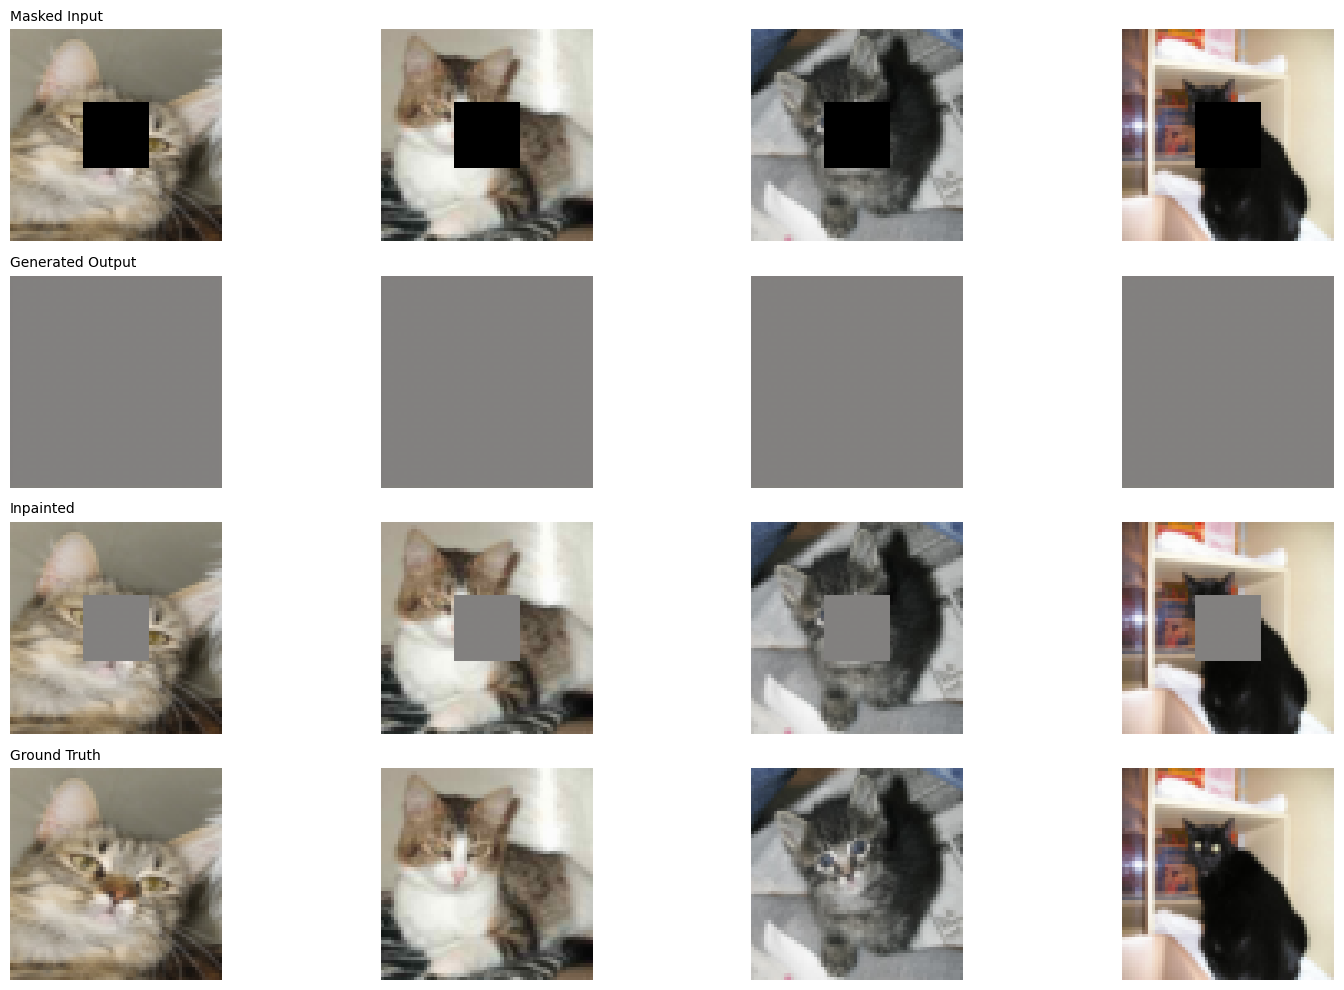

Epoch [1/10], Step [1174/1174], Discriminator Loss: 1.3858, Generator Loss: 0.6819


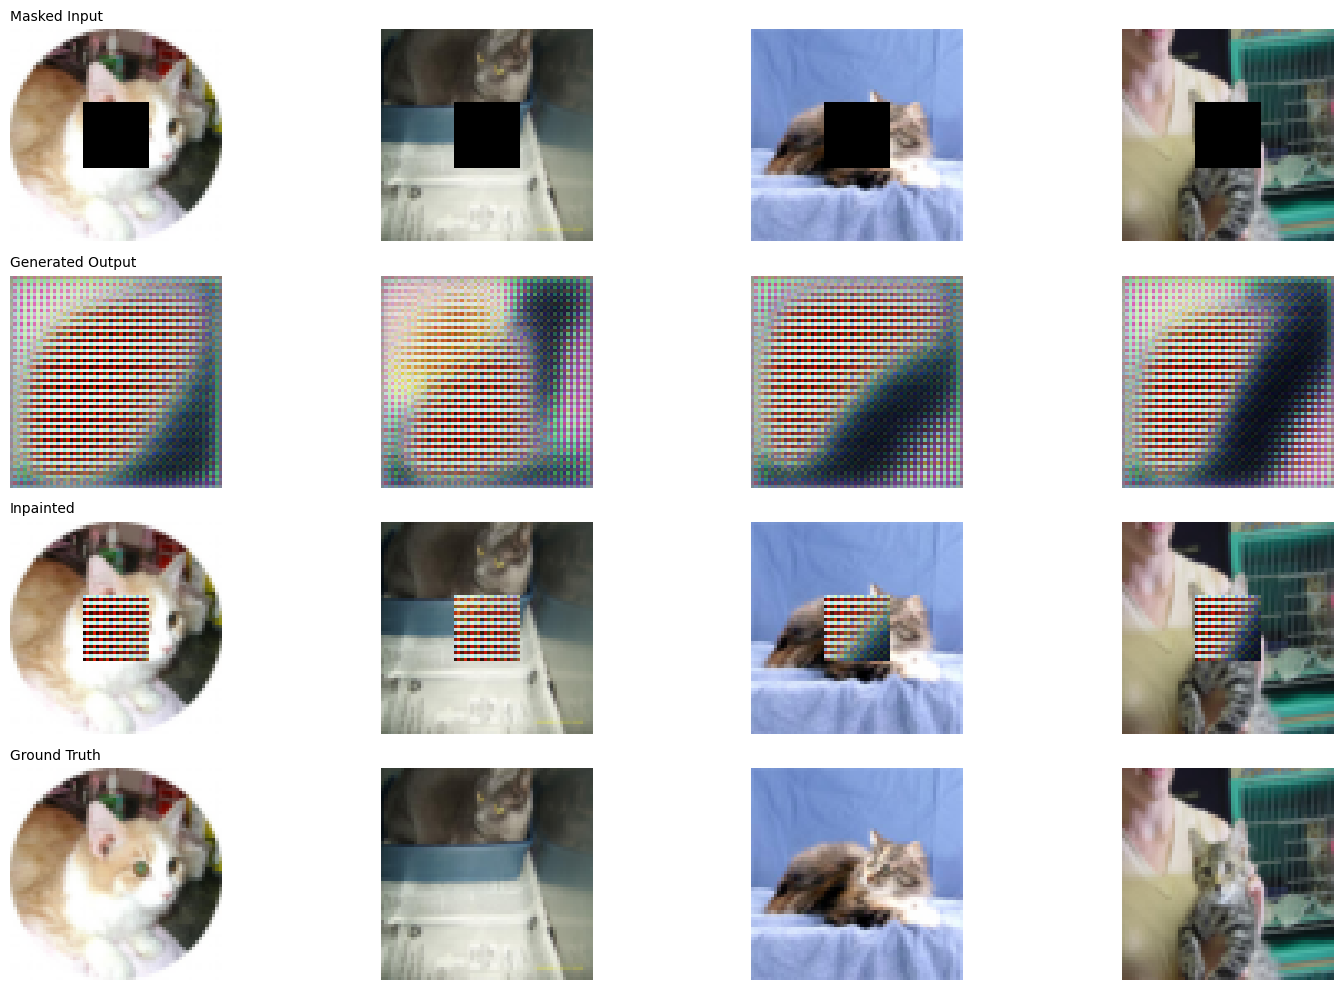

Epoch [2/10], Step [1174/1174], Discriminator Loss: 1.3757, Generator Loss: 0.7070


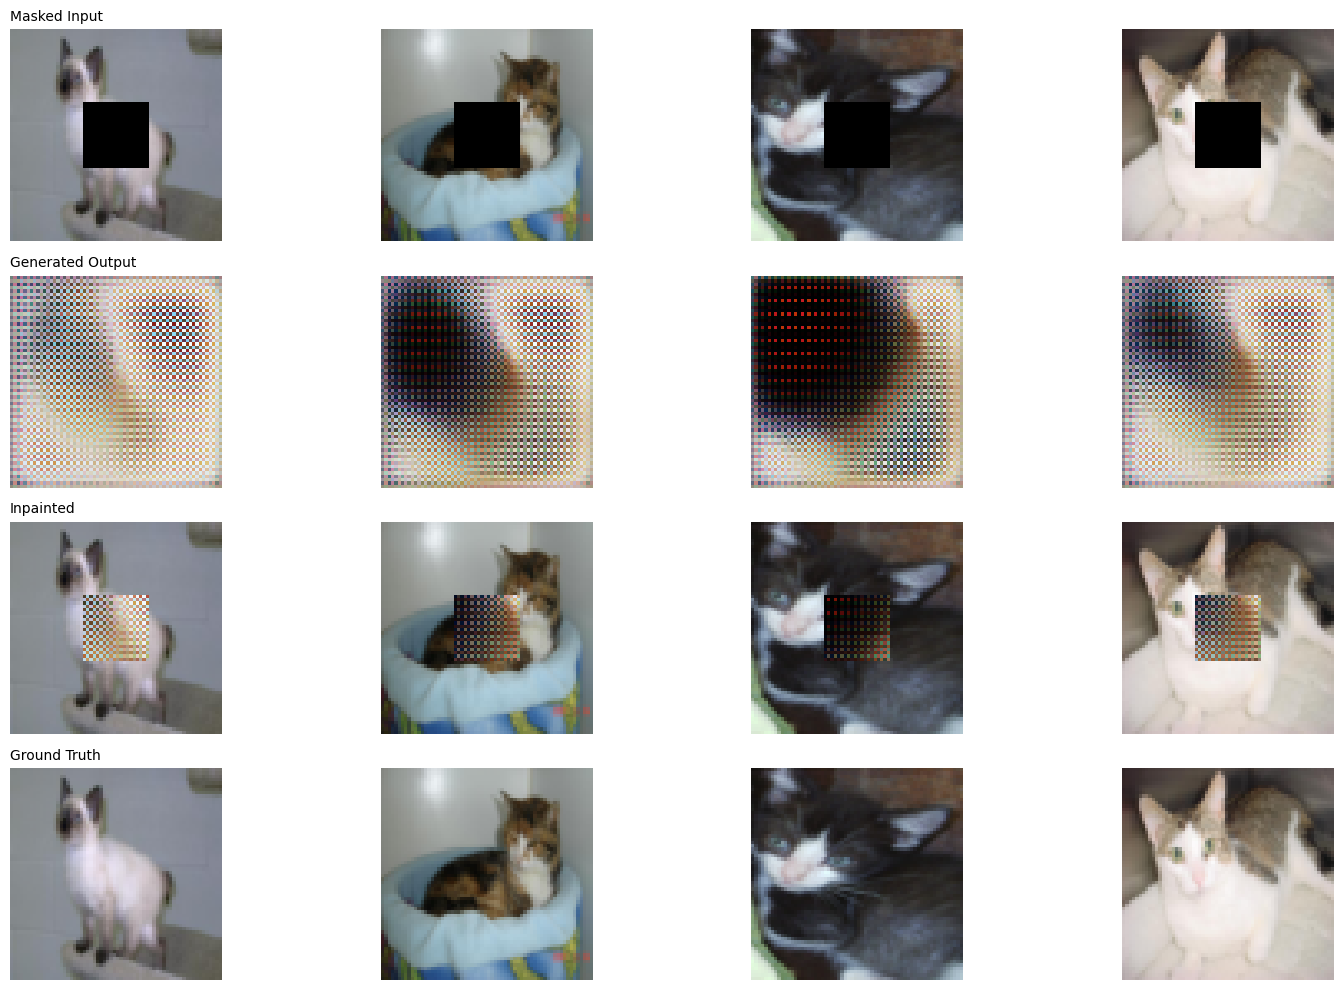

Epoch [3/10], Step [1174/1174], Discriminator Loss: 1.3277, Generator Loss: 0.7800


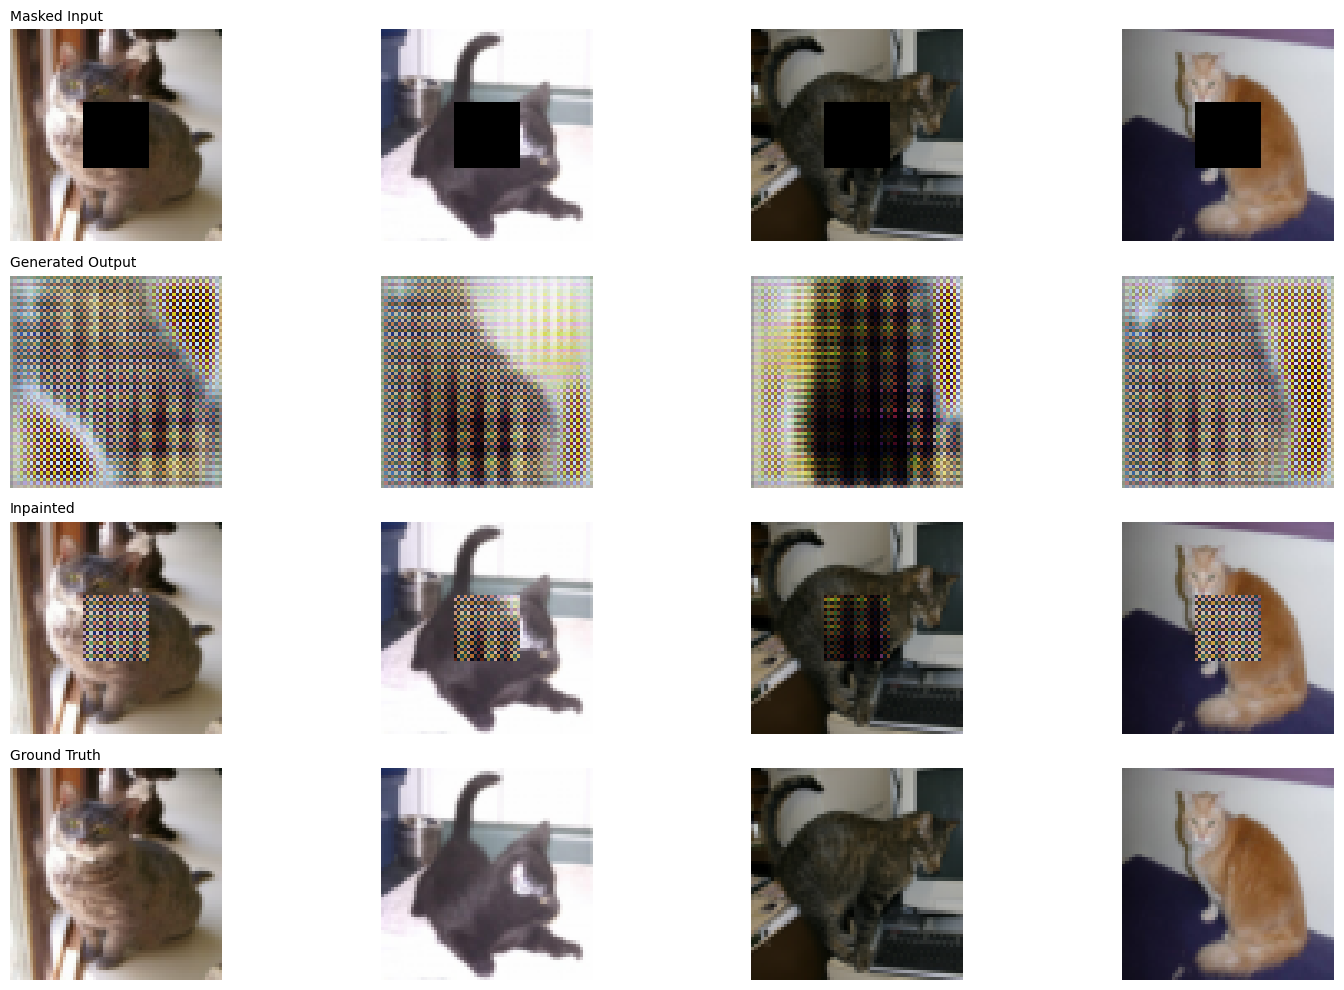

Epoch [4/10], Step [1174/1174], Discriminator Loss: 1.3354, Generator Loss: 0.7785


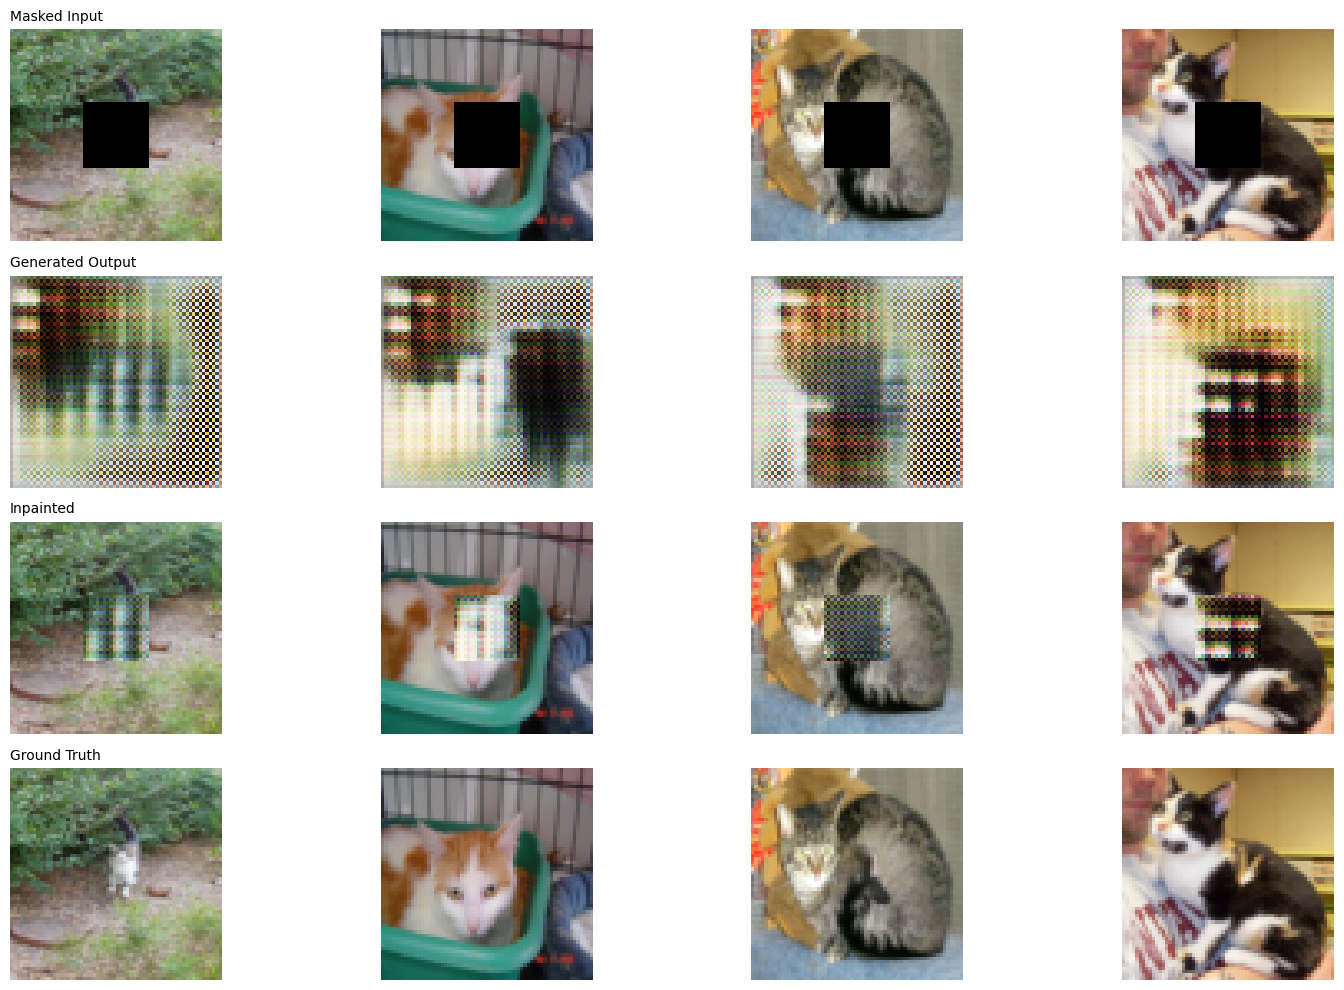

Epoch [5/10], Step [1174/1174], Discriminator Loss: 1.3120, Generator Loss: 0.8143


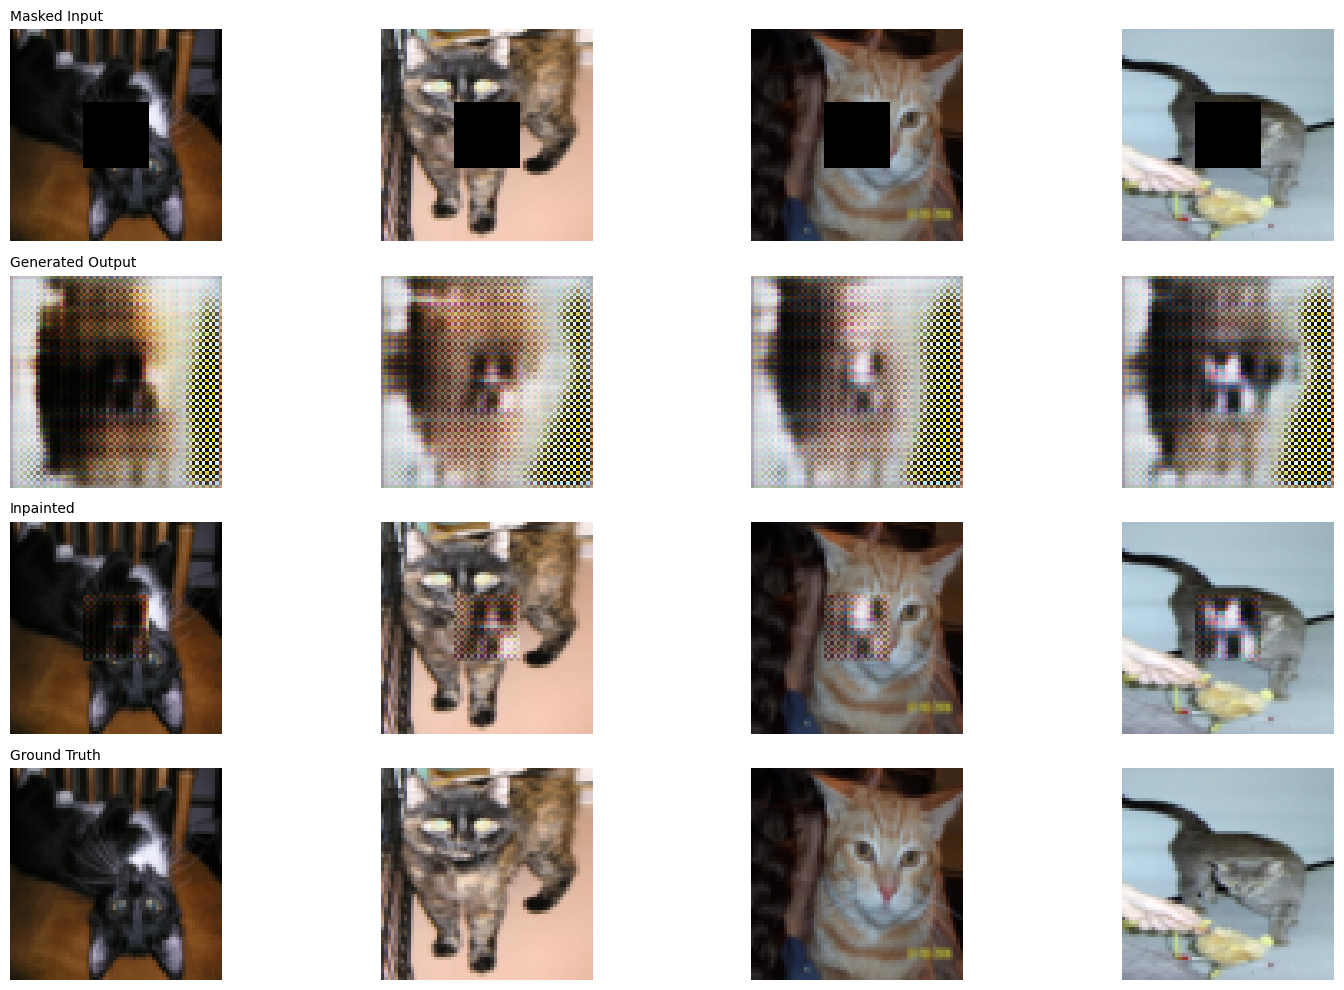

Epoch [6/10], Step [1174/1174], Discriminator Loss: 1.2511, Generator Loss: 0.9223


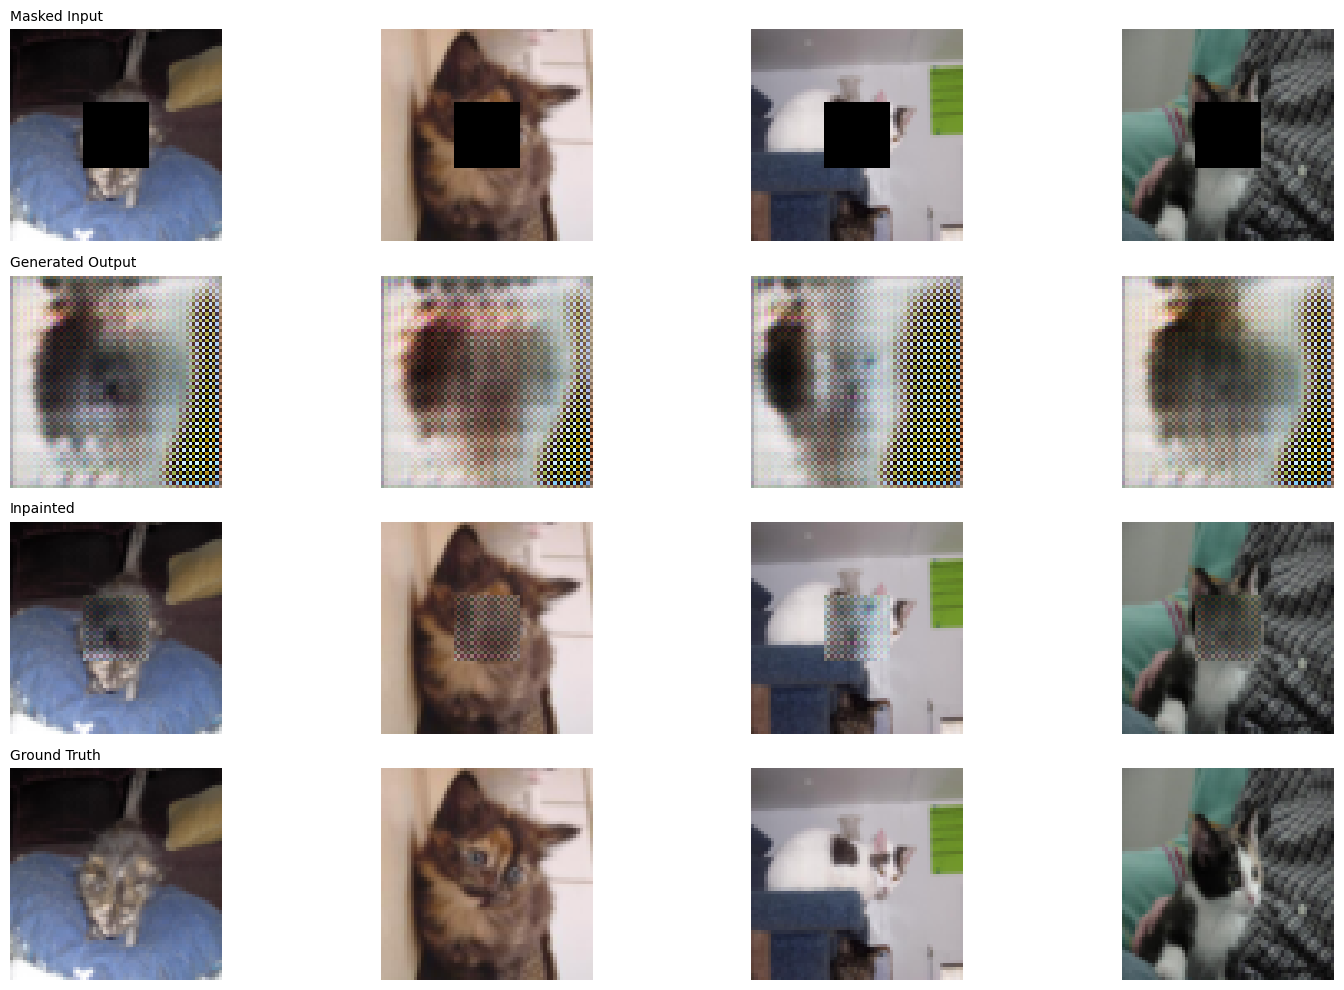

Epoch [7/10], Step [1174/1174], Discriminator Loss: 1.1215, Generator Loss: 1.1752


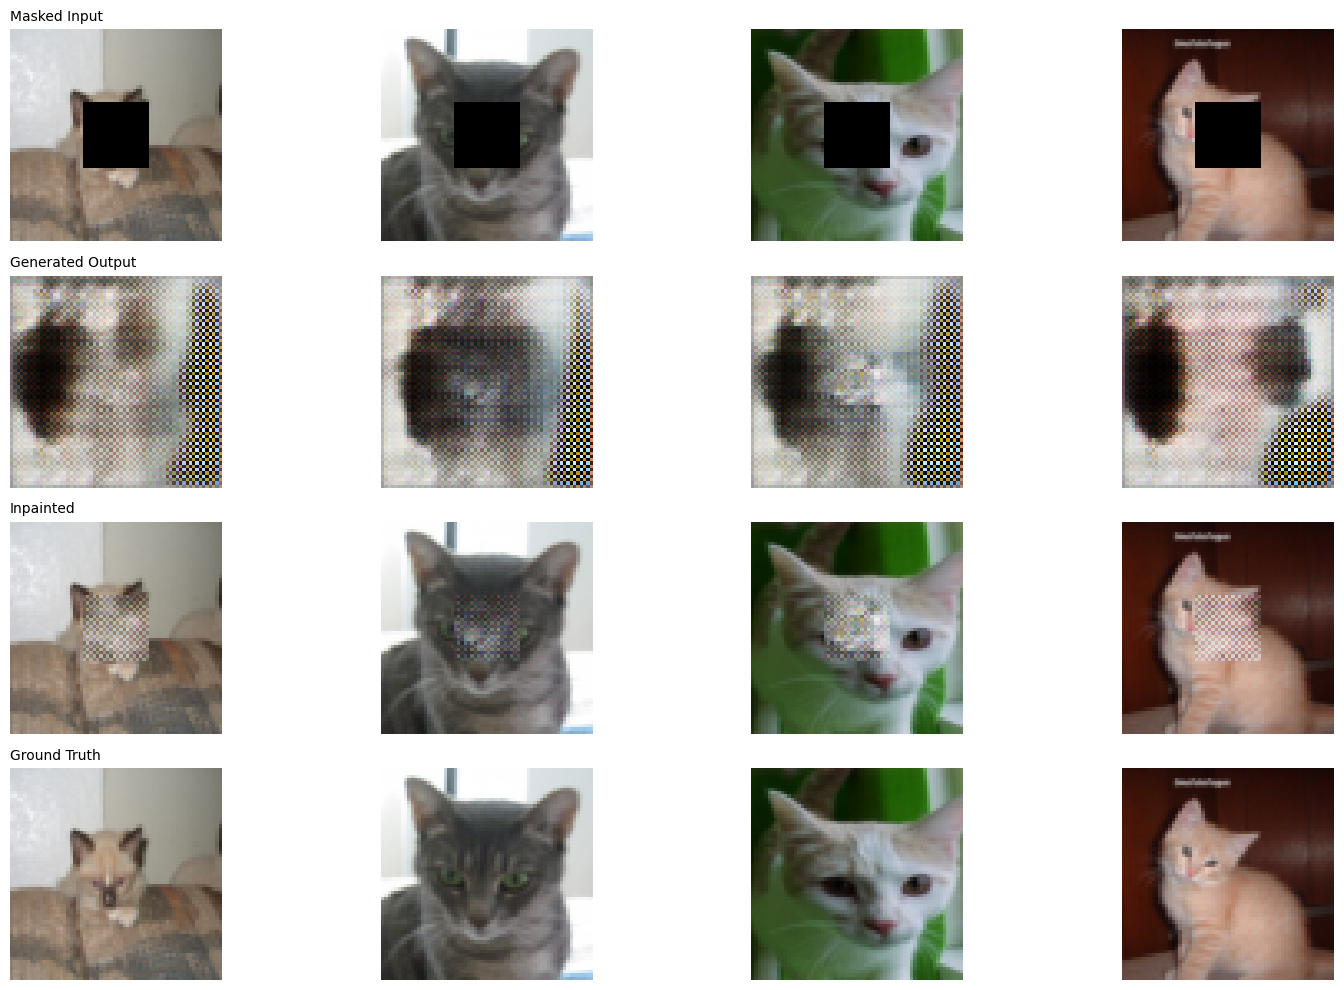

Epoch [8/10], Step [1174/1174], Discriminator Loss: 1.0138, Generator Loss: 1.3997


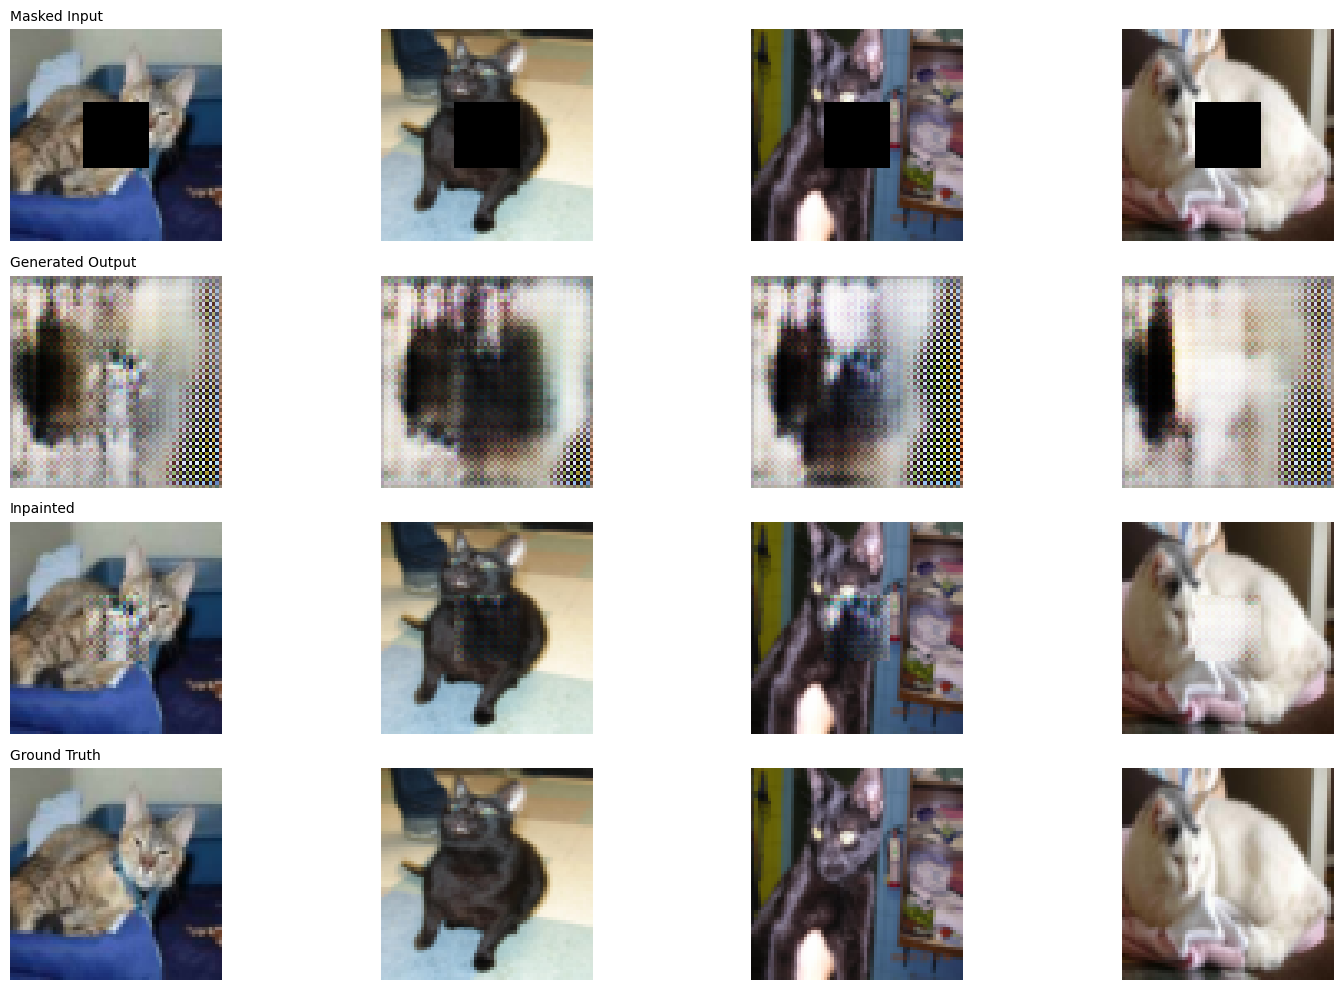

Epoch [9/10], Step [1174/1174], Discriminator Loss: 0.8902, Generator Loss: 1.7208


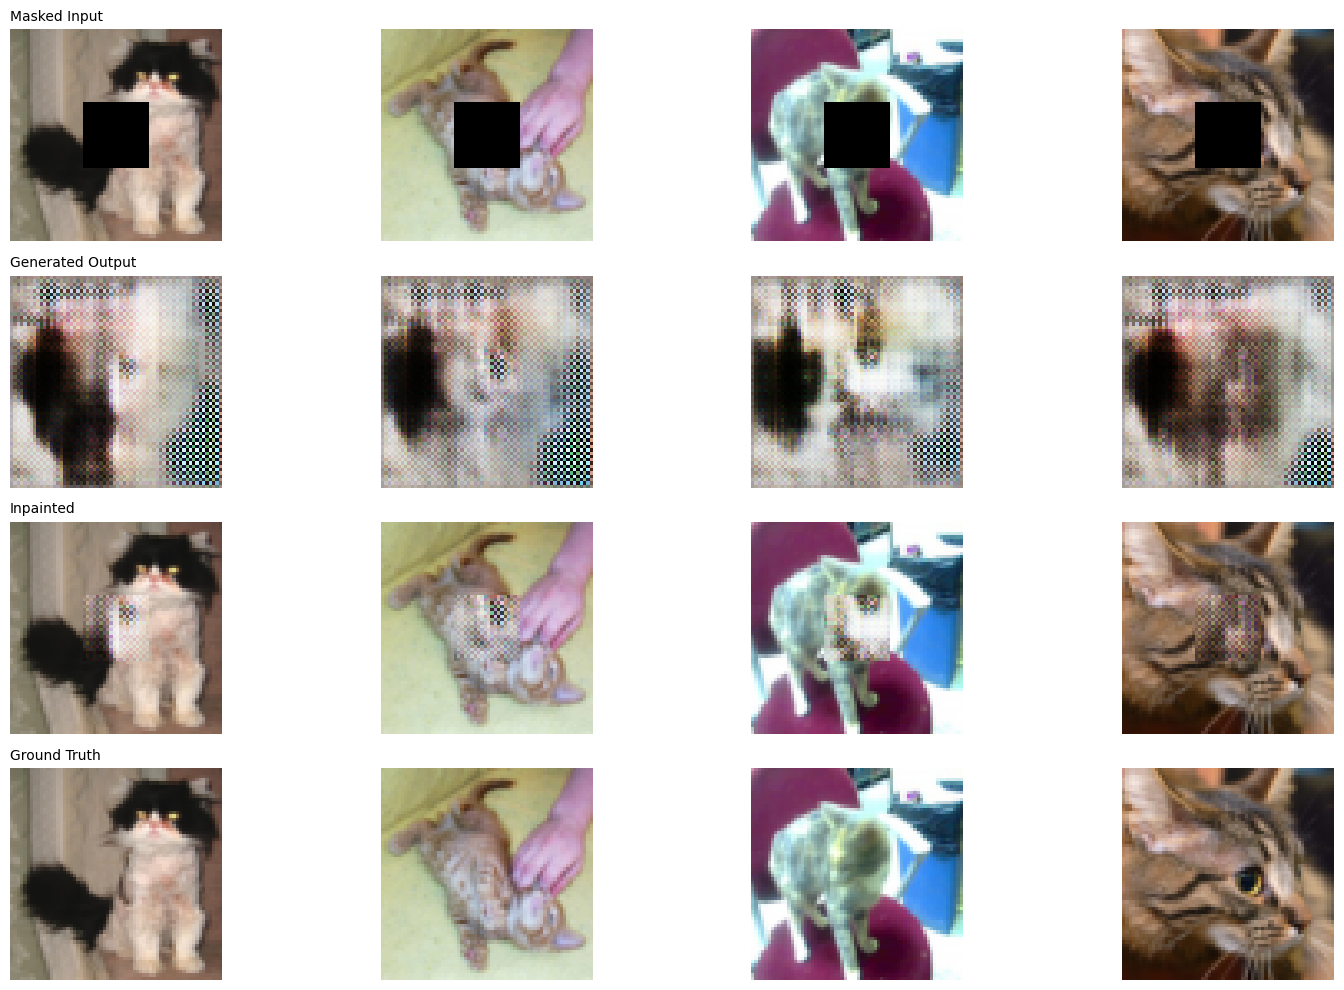

Epoch [10/10], Step [1174/1174], Discriminator Loss: 0.8669, Generator Loss: 1.8290


In [17]:
g = Generator(im_channels=3).to(device)
d = Discriminator().to(device)

optimizer_g = optim.Adam(g.parameters(), lr=0.0001)
optimizer_d = optim.Adam(d.parameters(), lr=0.0001)

criterion = nn.BCELoss()
num_epochs = 10

g_losses, d_losses = train(g, d, train_loader, val_loader, criterion, optimizer_g, optimizer_d, epochs=10, verbose=True, show_images=True)


## Training results

We find that the model's inpainting quality greatly improves with training. Reconstructing background elements is difficult in the beginning, frequently resulting in mismatched colors and shading, but these features improve significantly in later eras. Simpler cat body parts like the belly and legs are generated by the model fairly well, but it constantly fails to produce more complex facial features like the eyes, nose, and mouth—though it can occasionally produce eyes. One significant drawback is its inability to handle human features, like hands, which is still a known problem in generative modeling. All things considered, the picture clearly demonstrates the model's growing comprehension of texture and structure over time.

In [18]:
# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

Throughout training, this graph displays the discriminator's and generator's loss values. On average, the discriminator loss shows a distinct downward trend; the lower boundary of its oscillating curve gradually drops, taking the shape of a cone that gets smaller over time. On the other hand, the generator's baseline only slightly drifts downward, and its loss stays largely constant. As training goes on, both loss curves exhibit an intriguing pattern of rising volatility with larger value fluctuations. The source of this instability is unknown, but it doesn't seem to have a detrimental effect on the generated inpainted images' visual quality, indicating that average loss behavior is still trending in a productive direction. 

One thing to note is that the discriminator consistently has a lower loss than the generator. This makes sense considering the generator's job is "harder" than the discriminators in the beginning. During training, the discriminator has a set of ground truth images and fake images (generated by the generator) making the training and gradient calculation much more straightforward, while the generator has to generate images from scratch and its gradients depends on the discriminator's, which can make it much more unstable. Furthermore, the generator is very bad at generating "real" images in the beginning, so it is very easy for the discriminator to tell which ones are real and which ones are fake, making the discrimnator's loss significantly lower than the generator's. However, as training goes on, we can expect the two values to converge eventually, but since our epochs are fairly small, we can;t see the convergence in the graph. 

In [19]:
torch.save(g.state_dict(), f"initial_generator.pt")
torch.save(d.state_dict(), f"initial_discriminator.pt")

# 5. Experiments

The dynamic interaction between a generator and a discriminator is captured by the rich mathematical framework that underpins Generative Adversarial Networks (GANs). The mathematical viewpoint presented in [this blog](https://jaketae.github.io/study/gan-math/), which offers a formal and intuitive understanding of the adversarial training setup, served as our source of inspiration. The objective function formalizes the min-max optimization problem at the core of this framework:

$$
V(G, D) = \mathbb{E}_{x \sim p_{\text{data}}}[\log(D(x))] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$

This formulation supports our intuition: the generator aims to learn the true data distribution by producing outputs that the discriminator cannot distinguish from real data. To support this goal, we explored several loss functions beyond the adversarial objective—specifically L1, L2, and Huber loss. L1 loss (mean absolute error) is more robust to outliers and encourages sparsity, while L2 loss (mean squared error) penalizes larger errors more heavily, leading to smoother predictions. Huber loss offers a balance between the two, behaving like L2 for small errors and L1 for large ones. By experimenting with these loss functions, we aimed to better guide the generator during training and enhance the quality of inpainted outputs.


In [20]:
def get_trained_model_or_train(experiment_name, experiment_params):
    model_dir = f"models/{experiment_name}"
    if os.path.exists(model_dir):
        print(f"Found Experiment {experiment_name}")
        trained_generator = Generator(im_channels=3).to(device)
        trained_discriminator = Discriminator().to(device)
        trained_generator.load_state_dict(torch.load(f"{model_dir}/generator.pt"))
        trained_discriminator.load_state_dict(torch.load(f"{model_dir}/discriminator.pt"))

        # Load losses if they exist
        g_losses_path = f"{model_dir}/g_losses.pt"
        d_losses_path = f"{model_dir}/d_losses.pt"
        g_losses = torch.load(g_losses_path) if os.path.exists(g_losses_path) else []
        d_losses = torch.load(d_losses_path) if os.path.exists(d_losses_path) else []

        return trained_generator, trained_discriminator, g_losses, d_losses
    else:
        generator = Generator(im_channels=3).to(device)
        discriminator = Discriminator().to(device)

        g_losses, d_losses = train(g=generator, d=discriminator, **experiment_params)
        os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
        torch.save(generator.state_dict(), f"{model_dir}/generator.pt")
        torch.save(discriminator.state_dict(), f"{model_dir}/discriminator.pt")

        # Save losses
        torch.save(g_losses, f"{model_dir}/g_losses.pt")
        torch.save(d_losses, f"{model_dir}/d_losses.pt")

        return generator, discriminator, g_losses, d_losses

# 5.1 L1 Loss

In [21]:
optimizer_g = optim.Adam(g.parameters(), lr=0.0001)
optimizer_d = optim.Adam(d.parameters(), lr=0.0001)
criterion = nn.L1Loss()
num_epochs = 10

g, d, g_losses, d_losses = get_trained_model_or_train(
    experiment_name="l1_loss",
    experiment_params={
        "train_loader": train_loader,
        "val_loader": val_loader,
        "criterion": criterion,
        "optimizer_g": optimizer_g,
        "optimizer_d": optimizer_d,
        "epochs": num_epochs,
        "verbose": True,
        "show_images": False
    }
)

Epoch [1/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4750
Epoch [2/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4750
Epoch [3/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4750
Epoch [4/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4750
Epoch [5/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4750
Epoch [6/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4749
Epoch [7/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4750
Epoch [8/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4750
Epoch [9/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4750
Epoch [10/10], Step [1174/1174], Discriminator Loss: 1.0000, Generator Loss: 0.4750


# 5.2 L2 (MSE) Loss
MSELoss and L1Loss not seemed to work with our model?? Could just scrap later

In [28]:
optimizer_g = optim.Adam(g.parameters(), lr=0.0001)
optimizer_d = optim.Adam(d.parameters(), lr=0.0001)
criterion = nn.MSELoss()
num_epochs = 10

g, d, g_losses, d_losses = get_trained_model_or_train(
    experiment_name="l2_loss",
    experiment_params={
        "train_loader": train_loader,
        "val_loader": val_loader,
        "criterion": criterion,
        "optimizer_g": optimizer_g,
        "optimizer_d": optimizer_d,
        "epochs": num_epochs,
        "verbose": True,
        "show_images": False
    }
)

Epoch [1/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203
Epoch [2/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203
Epoch [3/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203
Epoch [4/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203
Epoch [5/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203
Epoch [6/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203
Epoch [7/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203
Epoch [8/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203
Epoch [9/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203
Epoch [10/10], Step [1174/1174], Discriminator Loss: 0.5086, Generator Loss: 0.3203


# 5.3 Huber loss TODO???



In [29]:
optimizer_g = optim.Adam(g.parameters(), lr=0.0001)
optimizer_d = optim.Adam(d.parameters(), lr=0.0001)
criterion = nn.HuberLoss()
num_epochs = 10

g, d, g_losses, d_losses = get_trained_model_or_train(
    experiment_name="huber_loss",
    experiment_params={
        "train_loader": train_loader,
        "val_loader": val_loader,
        "criterion": criterion,
        "optimizer_g": optimizer_g,
        "optimizer_d": optimizer_d,
        "epochs": num_epochs,
        "verbose": True,
        "show_images": False
    }
)


Epoch [1/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182
Epoch [2/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182
Epoch [3/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182
Epoch [4/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182
Epoch [5/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182
Epoch [6/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182
Epoch [7/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182
Epoch [8/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182
Epoch [9/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182
Epoch [10/10], Step [1174/1174], Discriminator Loss: 0.2502, Generator Loss: 0.1182


In [24]:
# Load pre-trained models
g = Generator(im_channels=3).to(device)
d = Discriminator().to(device)

g.load_state_dict(torch.load("initial_generator.pt", map_location=device))
d.load_state_dict(torch.load("initial_discriminator.pt", map_location=device))


<All keys matched successfully>


TODO? maybe write a function that will display the inpainting capabilities of each of the trained models depending on their loss function. Similar to how the "validation" cell is doing it below. but prob can only do this if can get the different loss functions to work 😞






# 6. Validation

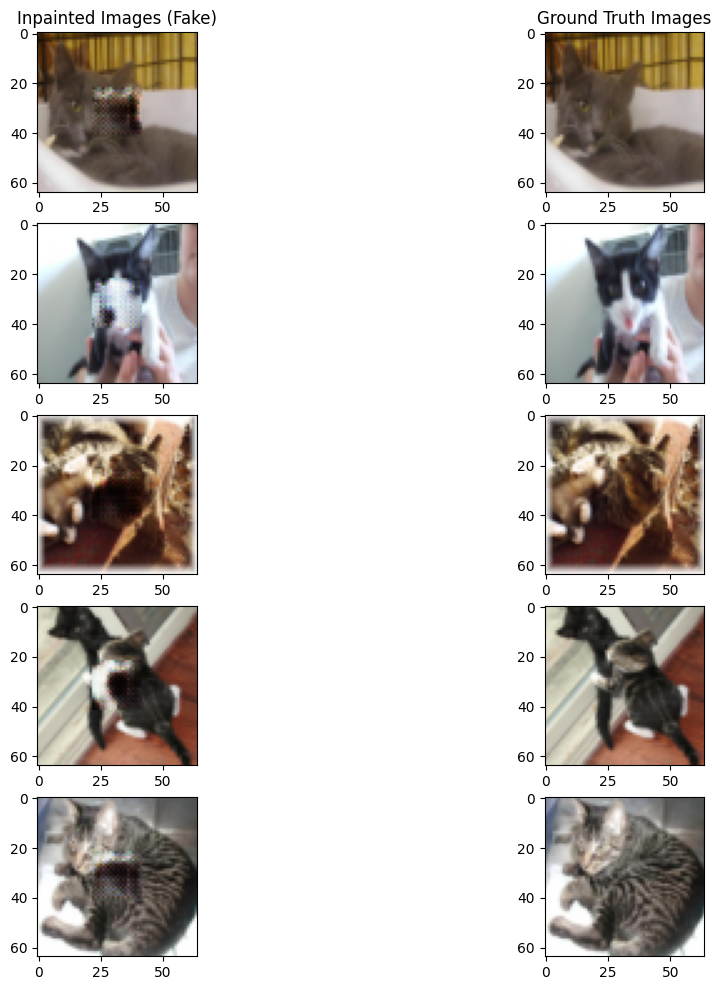

Number of Validation Images: 88, Average Discriminator Loss: 0.1067, Average Generator Loss: 0.1067


In [27]:
# Shows results after training
num_evaluation = 10
num_image_display = 5
val_iter = iter(val_loader)

# Loss
g_tot_loss = 0
d_tot_loss = 0
num_total = 1

# Validate GAN
f, ax = plt.subplots(num_image_display, 2, figsize=(12, 12))
ax[0, 0].set_title("Inpainted Images (Fake)")
ax[0, 1].set_title("Ground Truth Images")
for i in range(num_evaluation):
  g.eval()
  d.eval()
  with torch.no_grad():
      val_batch = next(val_iter)
      val_masked, val_truth = val_batch
      N = len(val_masked)

      # Move validation data to GPU
      val_masked = val_masked.to(device)
      val_truth = val_truth.to(device)
      N = len(val_masked)

      # Get labels
      true_labels = torch.ones(N).to(device)
      fake_labels = torch.zeros(N).to(device)

      val_masks = create_masks(N).to(device)
      val_masked = torch.cat((val_masked, val_masks), dim=1)

      # Get the inpainted image using the generator
      fake_im = g(val_masked)
      inpainted = fake_im * val_masks[0] + val_masked[:, :3, :, :]
      outputs = d(inpainted).view(-1)

      d_tot_loss += criterion(outputs, fake_labels).item()
      g_tot_loss += criterion(outputs, true_labels).item()
      num_total += 1

      if (i < num_image_display):
        # Display first sample
        ax[i, 0].imshow(inpainted[0].cpu().permute(1, 2, 0))
        ax[i, 1].imshow(val_truth[0].cpu().permute(1, 2, 0))

plt.show()
print(f'Number of Validation Images: {num_total * N}, '
            f'Average Discriminator Loss: {d_tot_loss / num_total:.4f}, '
            f'Average Generator Loss: {g_tot_loss / num_total:.4f}')

# 7. Conclusions

Our DCGAN model demonstrated promising results in the object removal and inpainting task. It was able to generate visually plausible completions of the missing regions, especially for relatively uniform backgrounds like fur. However, the model still has clear room for improvement. Recent advances such as Stable Diffusion and other Transformer-based architectures have shown significant gains in generative tasks. Incorporating these state-of-the-art models, though computationally expensive, could potentially lead to more coherent and higher-quality results.

At the start of our project, we simplified the problem by always masking a fixed square at the center of each image. This made the task more controlled, but less practical for real-world applications. A more flexible approach would involve user-defined masks of arbitrary shape and size. Supporting custom masks would make the model far more robust and widely usable across different tasks. Future work could involve incorporating spatial attention or segmentation cues to guide such inpainting.

Training the model involved experimenting with several loss functions, including L1, L2, and Huber loss, which are commonly used for regression tasks. However, these losses did not yield stable or visually pleasing outputs in our setting. We eventually settled on binary cross-entropy (BCE) loss due to its alignment with the adversarial training objective and improved qualitative results. Still, finding the right balance between adversarial loss and reconstruction loss remains a challenge. Future exploration into hybrid loss strategies or perceptual loss may help improve output fidelity.

One significant challenge we encountered was the inconsistency in our dataset of cat images. Many images were not standardized—cats varied in position, lighting, and scale, and some images even included human hands or other distractions. These inconsistencies made it harder for the model to learn a clean background distribution. Moving forward, it may be beneficial to either cleanse the current dataset or switch to a more standardized and curated one. Starting with an easier dataset may also allow the model to learn more effectively before tackling more complex scenarios.

Another challenge was encountered was a problem with our training method that caused our GAN to not work as intended. Before, we would just pass the generated image straight into the discriminator. This caused our GAN to learn how to generate cat pictures from scratch, rather than filling in the "hole", as seen in the image below.
![wrong_cats](images/wrong_cats.png)

From this picture, we can see that the generated pictures vaguely resemble cats and don't really fit into the image once we overlay it with the actual image. To fix this issue, we would pass the "inpainted" image into the discriminator. We get this "inpainted" picture by adding the generated patch of the image into the hole of the original image. This allowed the GAN to focus on generating the missing portions of the images, rather than generating new pictures as a whole, and our GAN started working as intended.

For next steps, we can investigate the effects of having two discriminators where one is a local discriminator that analyzes the inpainted (generated) part of the image and a global discriminator that evaluates the image as a whole (as mentioned in [S. Iizuka, E. Simo-Serra, H. Ishikawa's paper](https://iizuka.cs.tsukuba.ac.jp/projects/completion/data/completion_sig2017.pdf)). The main idea behind this is that the local discriminator will evaluate the details of the inpainting, while the global discriminator evaluates the overall coherence and structure of the image. This will "encourage" the generator to create more detailed inpaintings while still preserving the overall structure of the image.  

# TODO:
testing that we can train with different loss functions

ok took out training with different losses outside of the get_trained_model_or_train function. so we know at least training on L2/MSE loss works. so need to fix get_trained_model_or_train

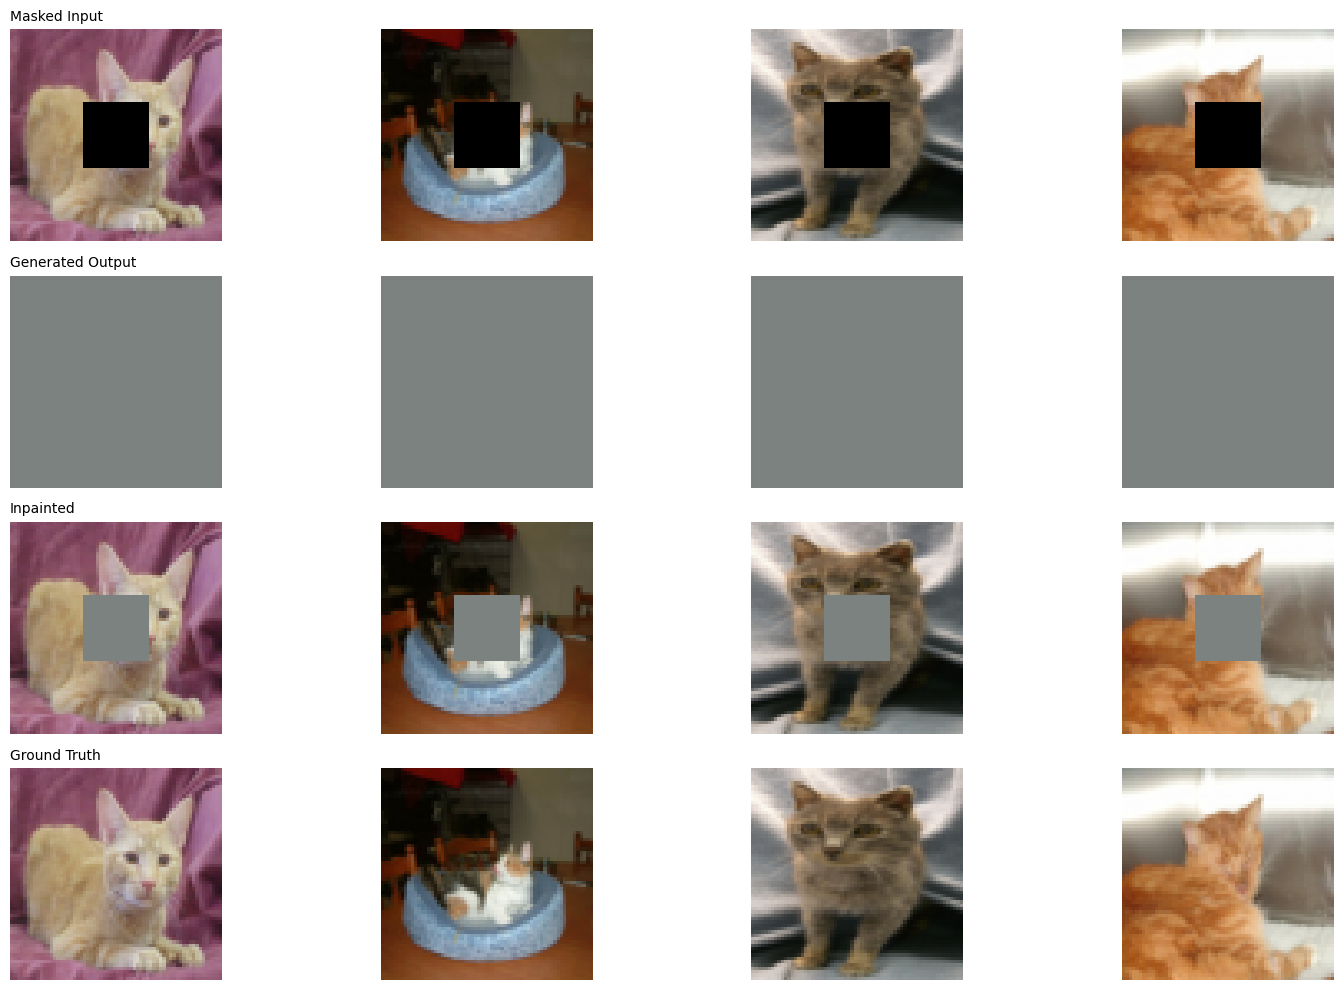

Epoch [1/10], Step [1174/1174], Discriminator Loss: 0.4995, Generator Loss: 0.2467


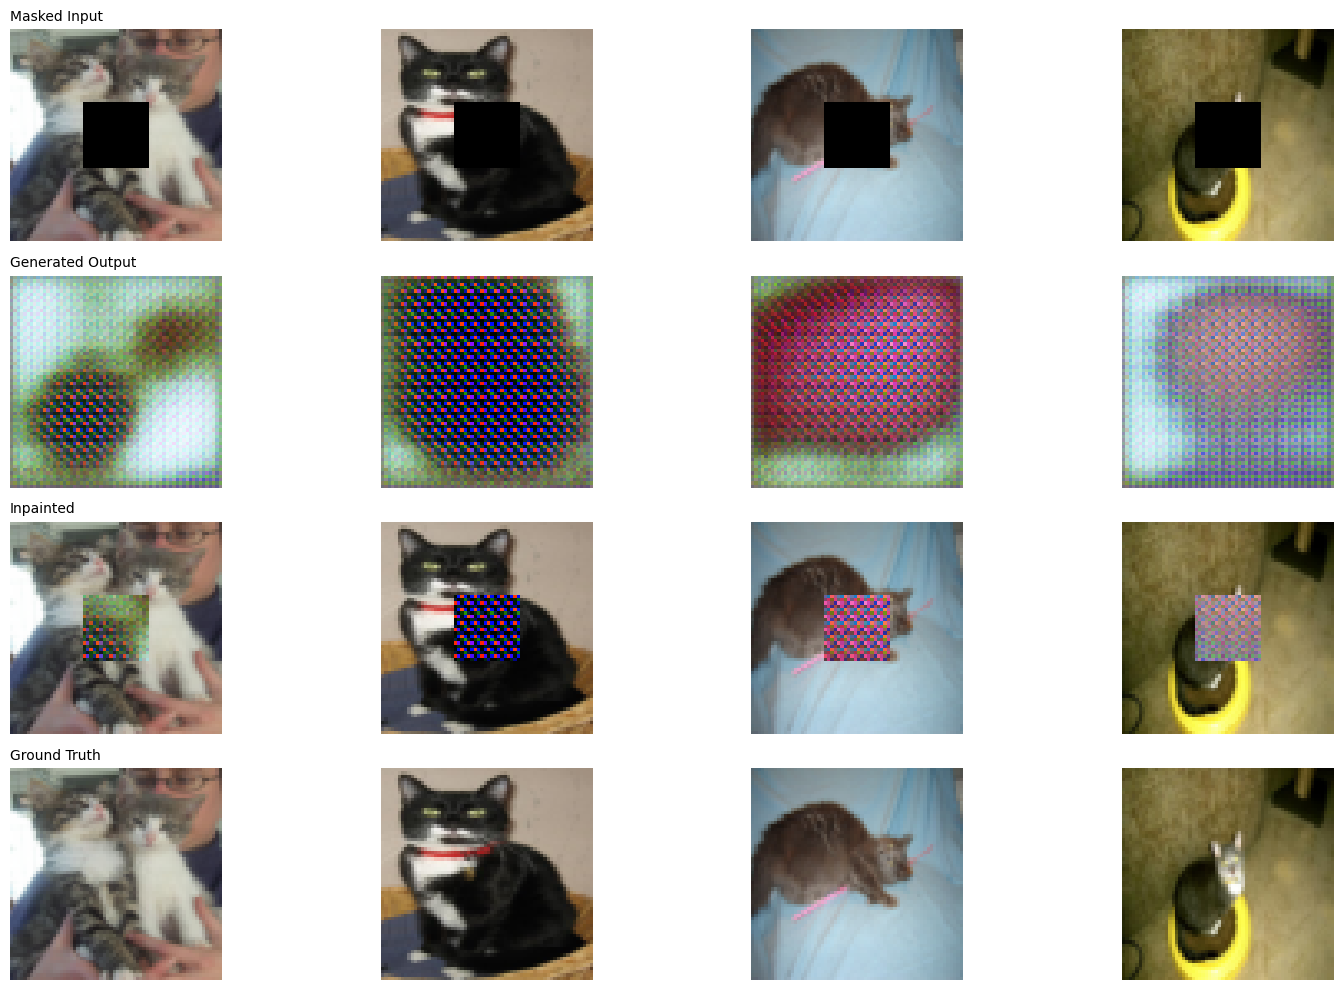

Epoch [2/10], Step [1174/1174], Discriminator Loss: 0.4948, Generator Loss: 0.2554


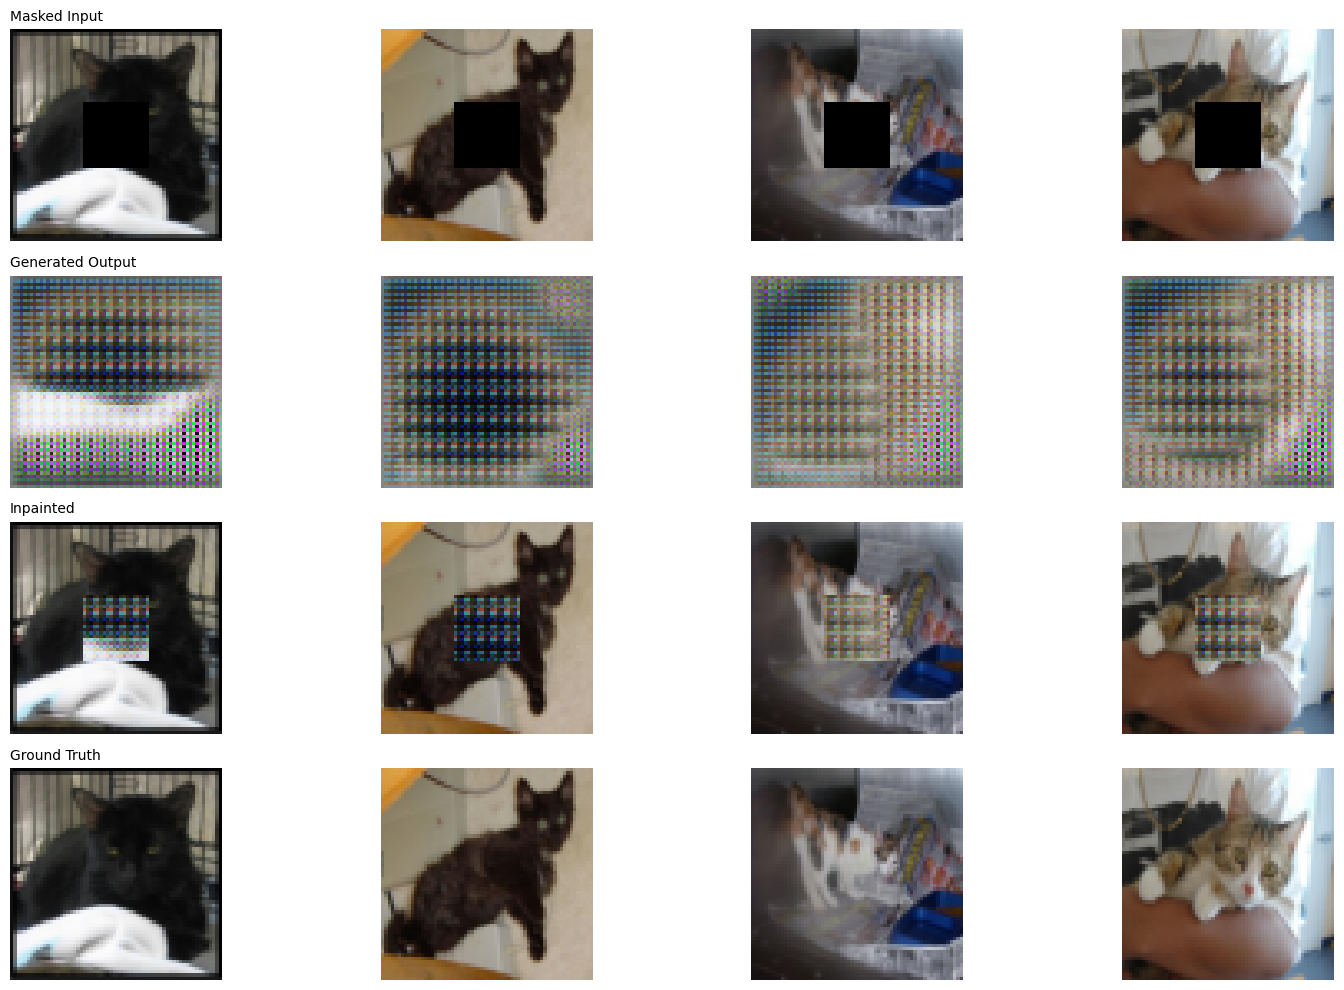

Epoch [3/10], Step [1174/1174], Discriminator Loss: 0.4777, Generator Loss: 0.2827


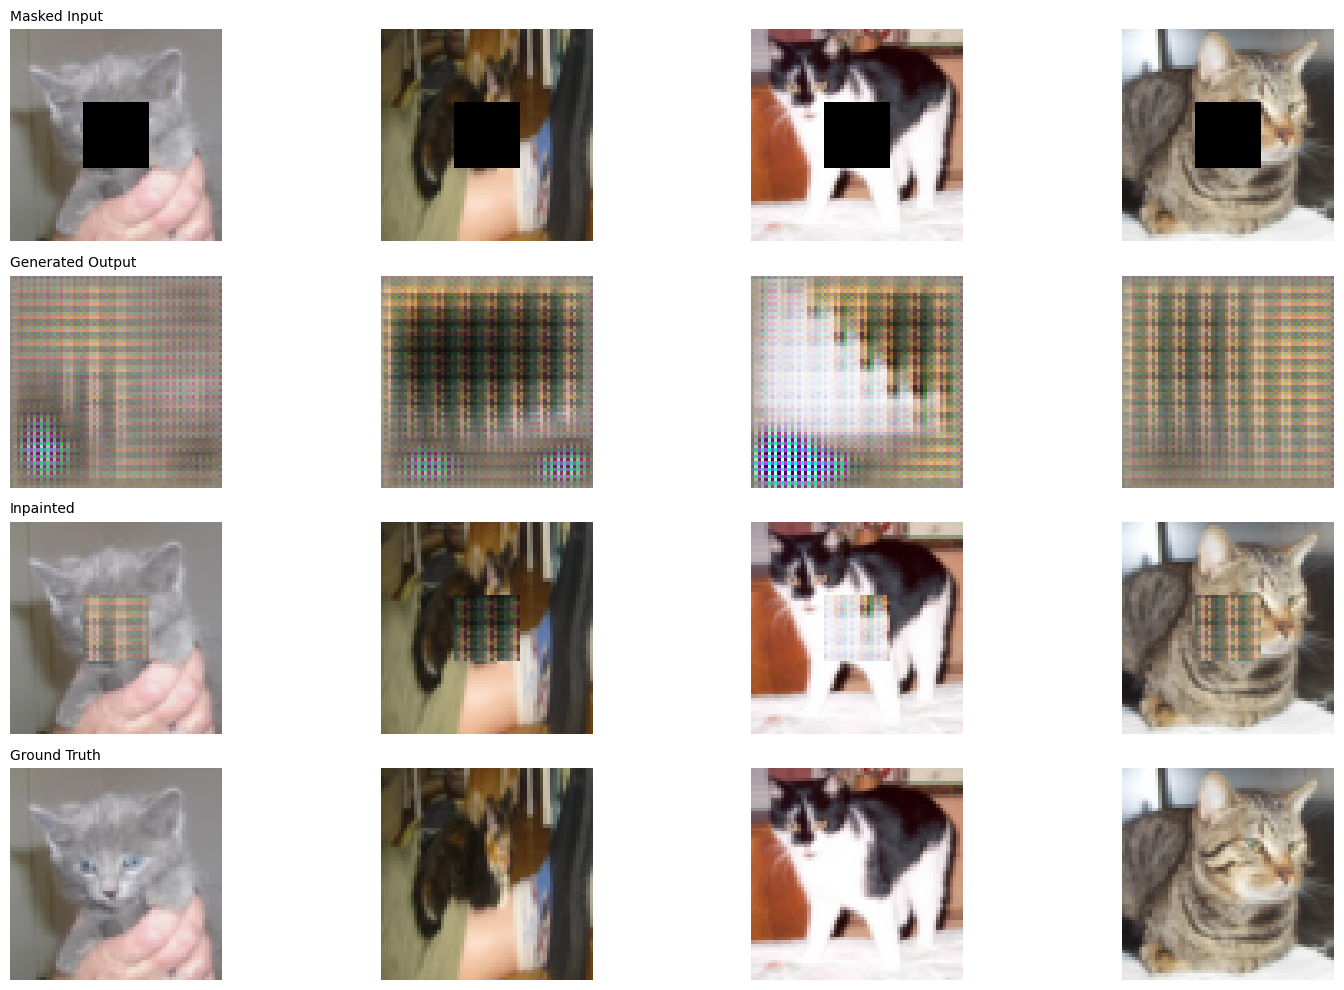

Epoch [4/10], Step [1174/1174], Discriminator Loss: 0.3780, Generator Loss: 0.4396


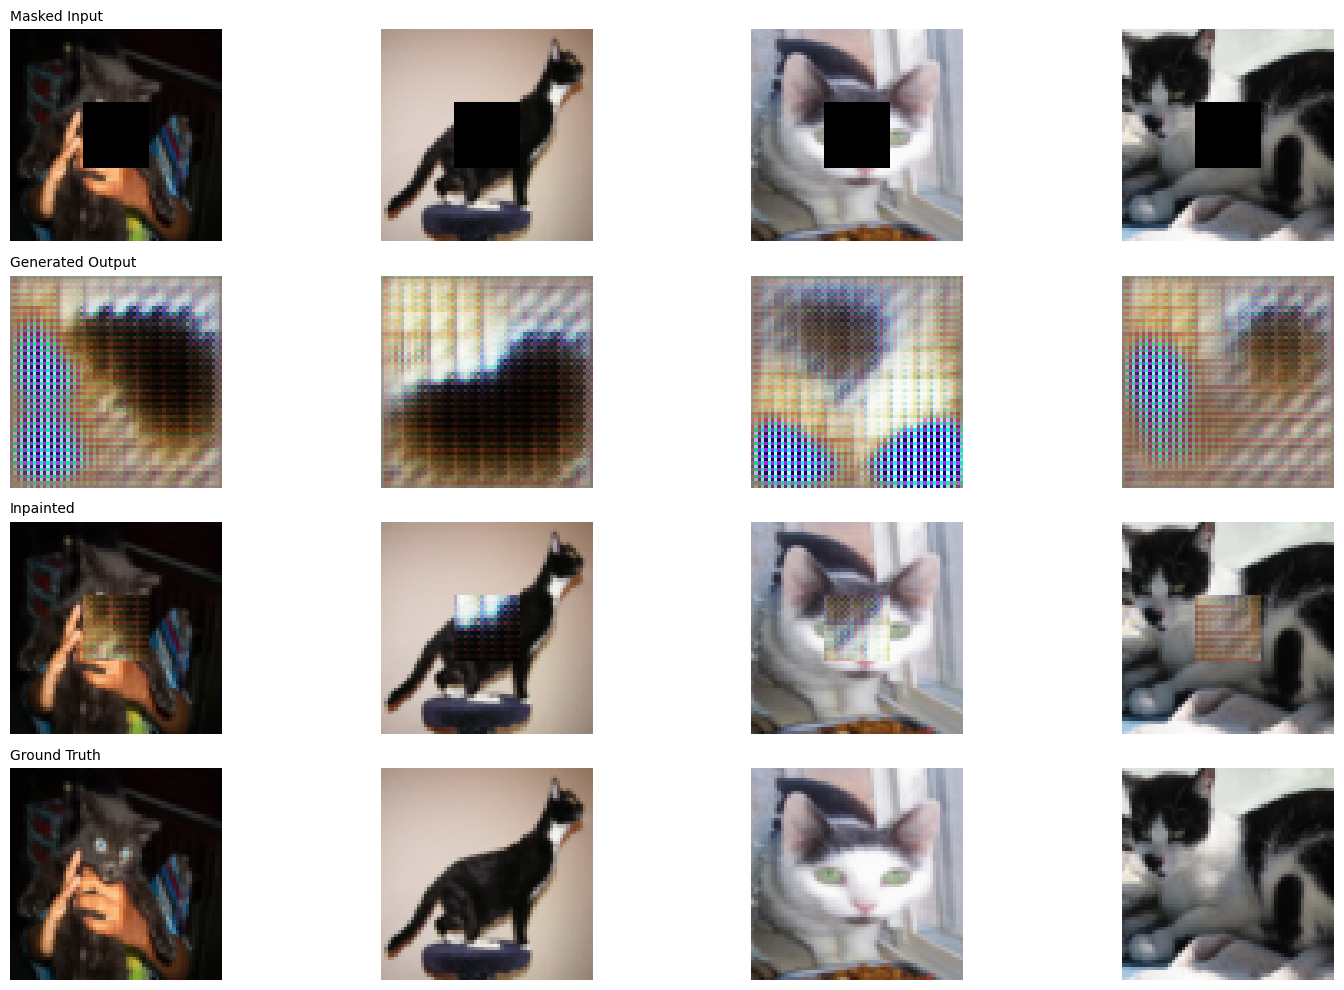

Epoch [5/10], Step [1174/1174], Discriminator Loss: 0.3573, Generator Loss: 0.4836


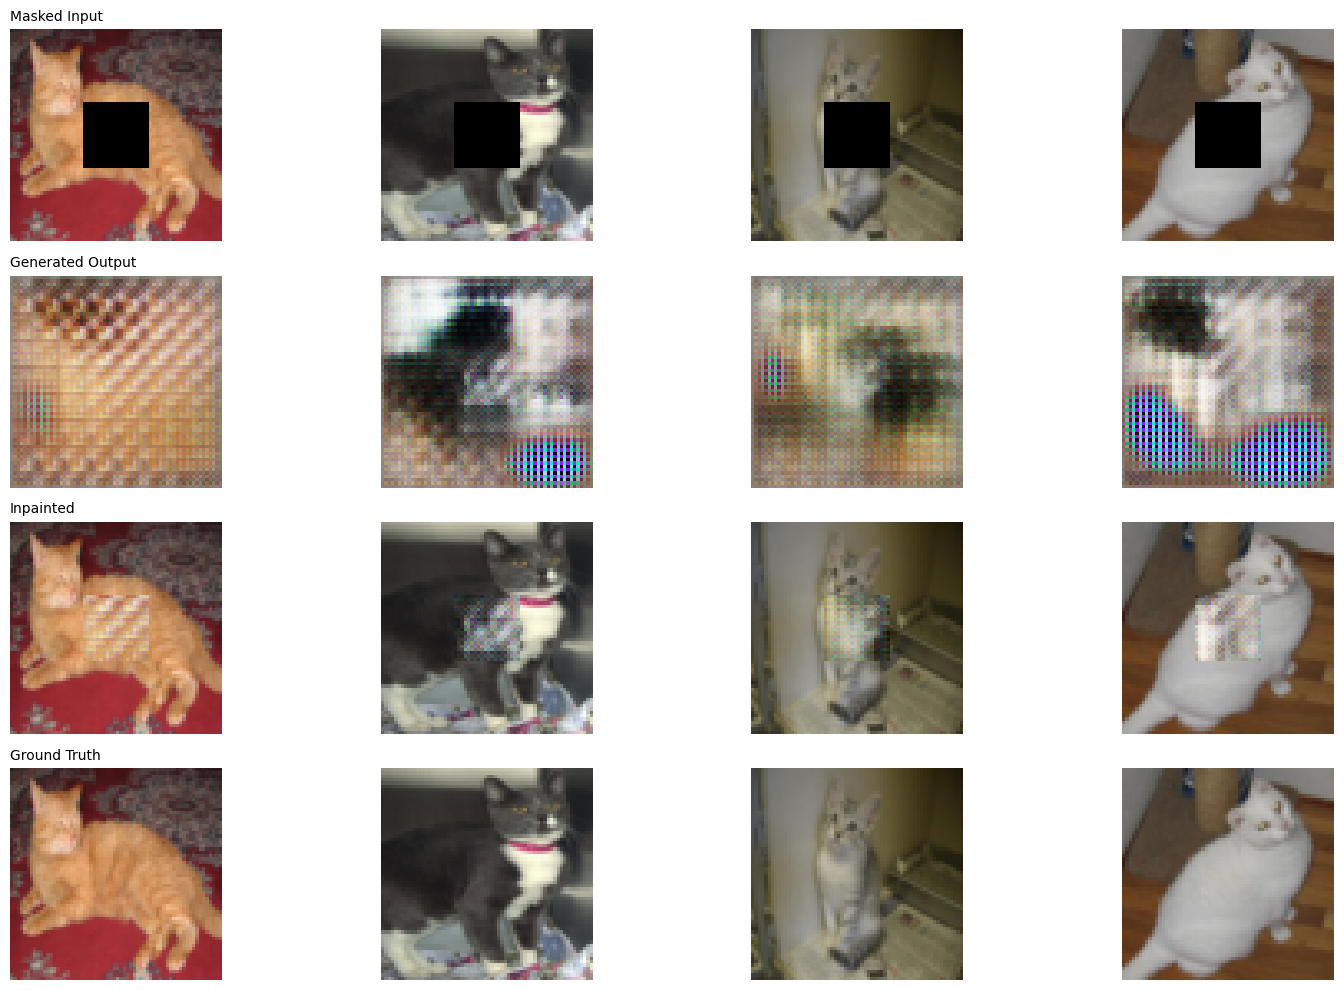

Epoch [6/10], Step [1174/1174], Discriminator Loss: 0.3531, Generator Loss: 0.4840


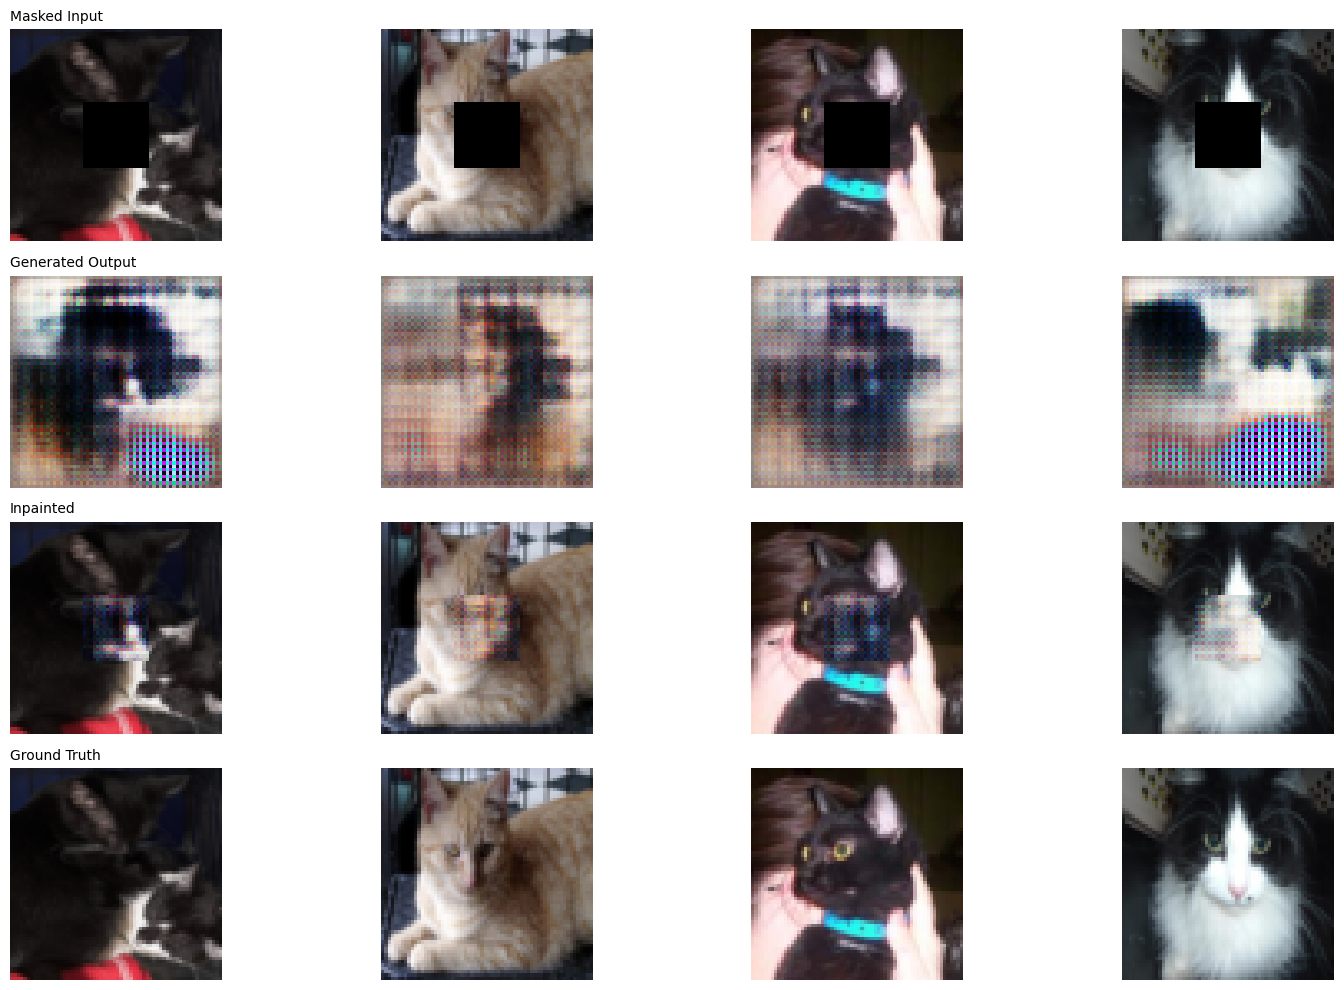

Epoch [7/10], Step [1174/1174], Discriminator Loss: 0.3211, Generator Loss: 0.5470


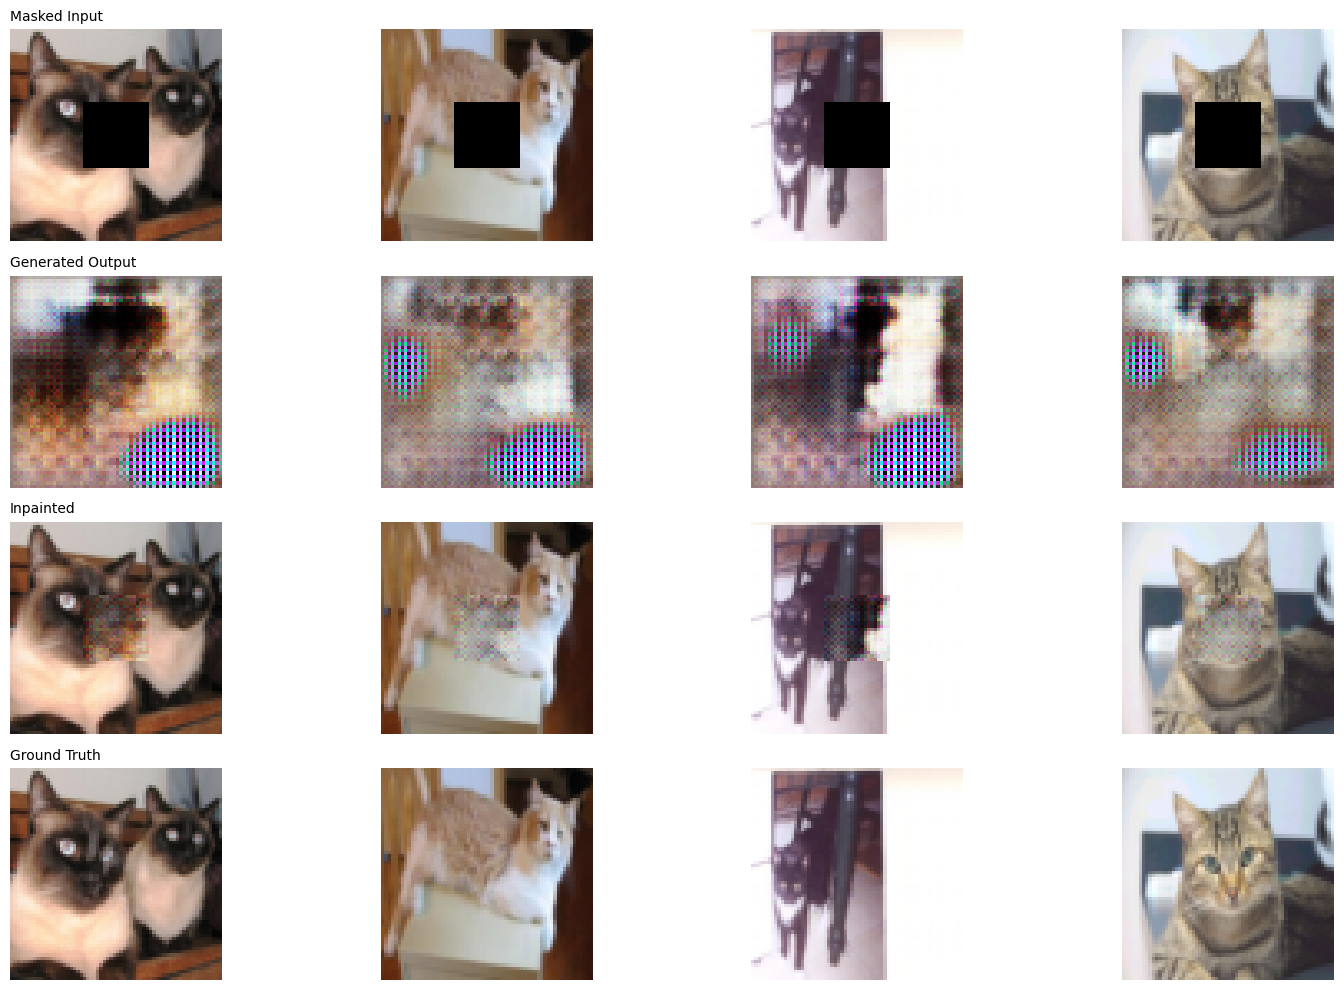

Epoch [8/10], Step [1174/1174], Discriminator Loss: 0.2863, Generator Loss: 0.5913


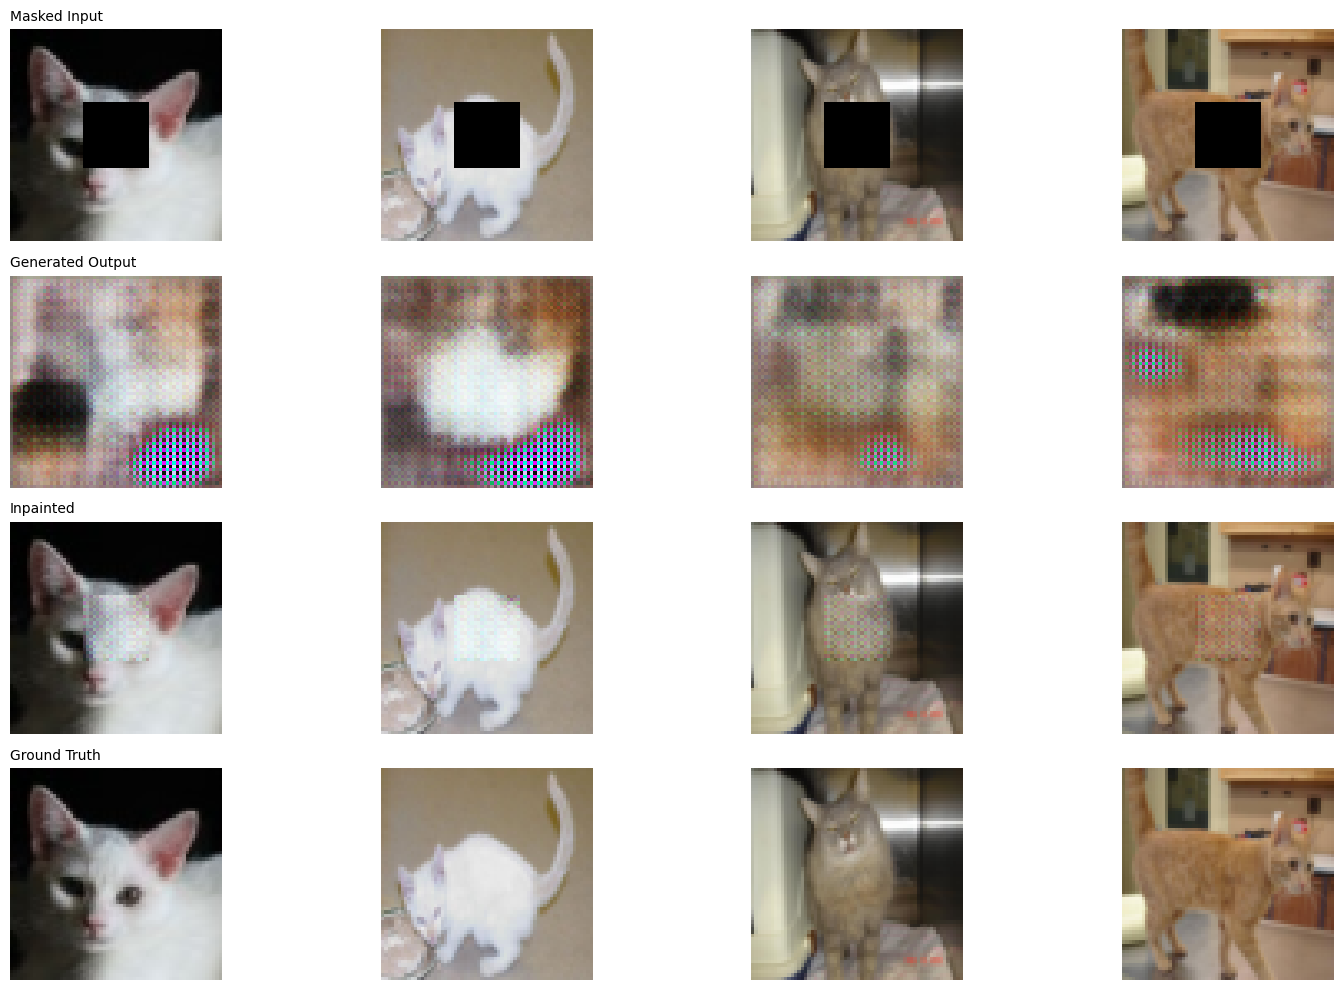

Epoch [9/10], Step [1174/1174], Discriminator Loss: 0.2582, Generator Loss: 0.6448


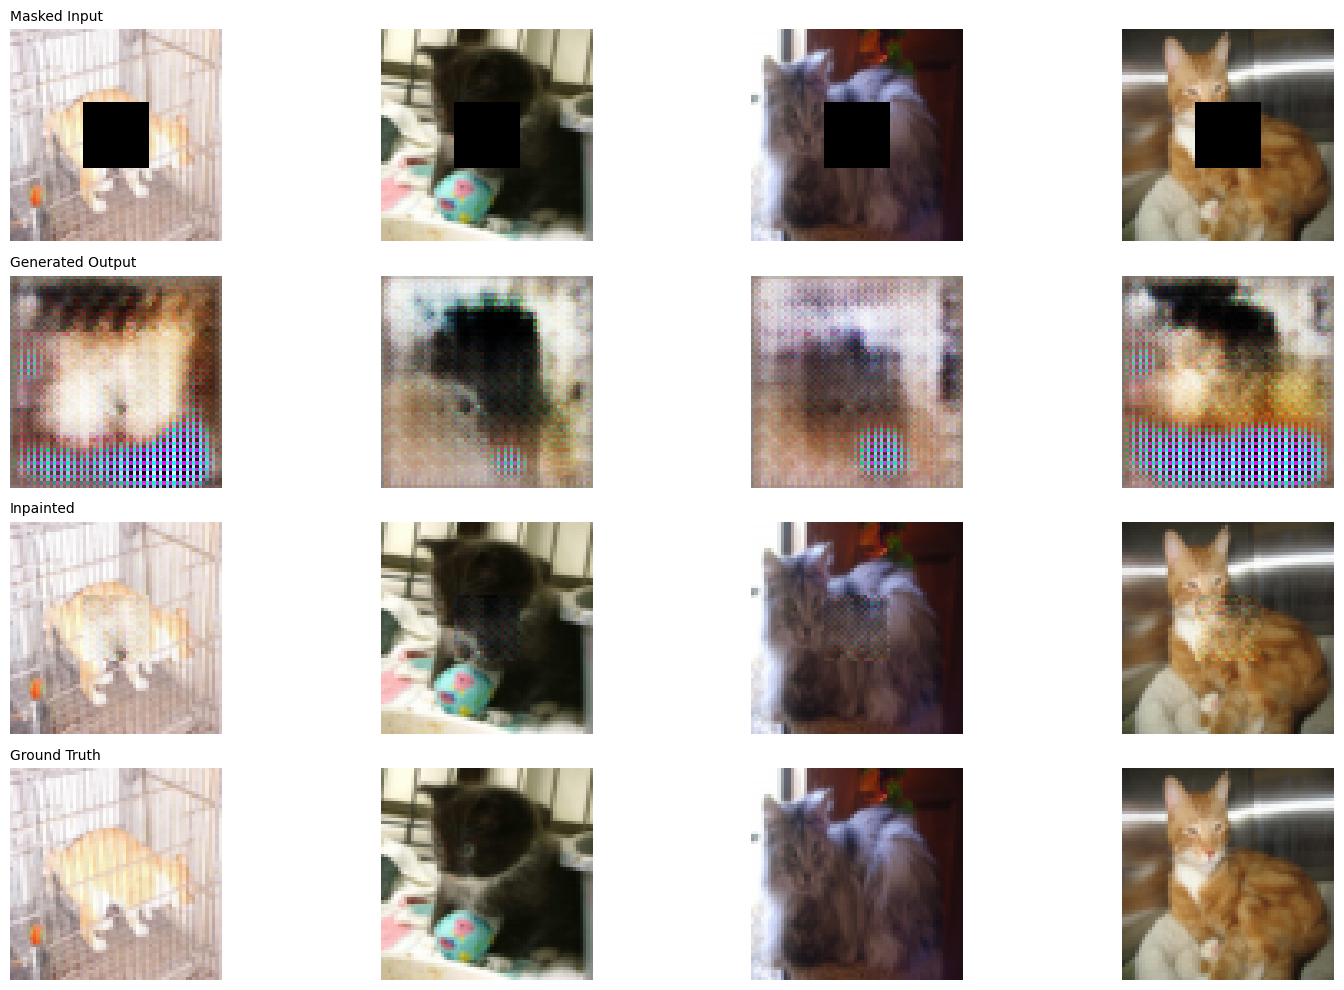

Epoch [10/10], Step [1174/1174], Discriminator Loss: 0.2364, Generator Loss: 0.6732


In [35]:
g = Generator(im_channels=3).to(device)
d = Discriminator().to(device)

optimizer_g = optim.Adam(g.parameters(), lr=0.0001)
optimizer_d = optim.Adam(d.parameters(), lr=0.0001)

criterion = nn.MSELoss(reduction="mean")
num_epochs = 10

g_losses, d_losses = train(g, d, train_loader, val_loader, criterion, optimizer_g, optimizer_d, epochs=10, verbose=True, show_images=True)


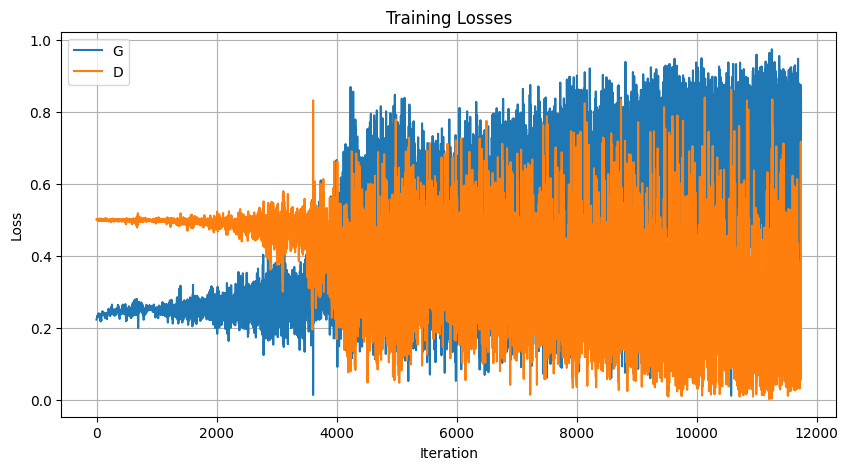

In [36]:
# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.show()